# 영화 시놉시스 코퍼스를 사용한 장르 간 편향성 측정하기

## 프로젝트 설명

1. 형태소 분석기를 이용하여 품사가 명사인 경우, 해당 단어를 추출하기
2. 추출된 결과로 embedding 모델 만들기
3. TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기
    1. 영화 장르, 영화 구분 정보를 기준 축으로 삼아 진행
    2. 영화 구분은 예술 영화, 일반 영화(상업 영화), 독립 영화
    3. 영화 장르는 SF, 가족, 공연, 공포(호러), 다큐멘터리, 드라마, 등
4. embedding 모델과 단어 셋으로 WEAT score 구해보기

5. 예시
    1. 예술영화와 일반 영화를 타겟으로 삼고, 드라마와 액션 장르를 attribute로 삼아 WEAT score 계산
    2. 가설 : 드라마 장르에는 예술영화적 성격이 강하고, 액션 장르에는 일반 영화적 성격이 강할 것이다.
        - 가설에서 볼 수 있는 편향성이 워드 임베딩에 얼마나 나타나고 있는지 측정해본다.
    3. 실험 방법
        - 예술 영화를 잘 나타나면서 일반영화에는 자주 나타나지 않는 단어를 선택하기 위해 TF-IDF를 사용한다. 다른 방법도 있을 수 있음.
        - TF-IDF가 높은 순으로 추출하되 양쪽에 중복된 단어가 많아 그 것을 제외하고 상위 15개(n개)의 단어를 추출한다.
        - 장르는 드라마와 액션 단 2개의 장르만 고려하는 것 보다 여러 장르를 두루 고려하는 것이 특정 장르를 대표하는 단어를 선택하는 데 더 유라할 것이므로 주요 장르 5개를 고려하여 TF-IDF를 진행한다. 여기서는 중복이 영화 구분 데이터에 비해 적으므로 그대로 사용한다.
        - target_X = art, target_Y = gen
        - attribute_A = '드라마', attribute_B = '액션'
        - target_X, target_Y는 고정 A,B를 바꿔가면서 구한 결과를 21x21 매트릭스 형태로 표현

6. 프로젝트에서는 영화 장르를 고정으로 두고 영화 구분의 편향성을 확인한다.

## 프로젝트 할당

- Word2Vec - CBoW
- Word2Vec - Skip-gram
- FastText

세 가지의 임베딩 모델을 각각 사용하여 실험을 진행한다.

토크나이저는 MeCab을 사용하며 target과 attribute에 사용할 단어 셋의 크기는 15로 한다.

결론에는 WEAT score의 heatmap, tsne 시각화를 포함시킨다.

## 프로젝트 루브릭

|학습 목표|평가 기준|
|---------|---------|
|주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.|워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.|
|영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.|타당한 방법론을 통해 중복이 잘 제거되고 <br>개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.|
|WEAT score 계산 및 시각화를 정상적으로 진행하였다.|전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 <br> 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.|

# 사전 환경 세팅

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/AIFFEL/Deep_Dive/work/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AIFFEL/Deep_Dive/work


# 라이브러리 설치 및 호출

## 라이브러리 설치

In [2]:
!pip install konlpy
!pip install sentencepiece
!pip install soynlp
!pip install gensim==4.3.2
# 의존성 연결을 위해 다운그레이드를 진행합니다.
# !pip install scipy==1.12.0 numpy==1.26.2
!apt-get install -y openjdk-17-jdk
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd ./Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab_light_220429.sh
%cd /content/drive/MyDrive/AIFFEL/Deep_Dive/work/make_vocab

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-17-jdk is already the newest version (17.0.16+8~us1-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
fatal: destination path 'Mecab-ko-for-Google-Colab' already exists and is not an empty directory.
/content/drive/MyDrive/AIFFEL/Deep_Dive/work/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2025-11-19 04:39:32--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 185.166.143.50, 185.166.143.49, 185.166.143.48, ...
Connecting to bitbucket.org (bitbucket.org)|185.166.143.50|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?response

In [3]:
!apt-get update -qq
!apt-get install -qq fonts-nanum


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


## 라이브러리 호출

In [4]:
import numpy
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt, Mecab
import seaborn as sns
import pandas as pd

import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

## 라이브러리 버전 확인

In [5]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.6.0
4.3.2
1.6.1
0.13.2


# 데이터 분석

## 데이터 다운로드 및 열기

In [6]:
import os

data_dir = os.path.join('/content/drive/MyDrive/AIFFEL/Deep_Dive', "work/weat/data")
file_name = os.path.join(data_dir, "synopsis.txt")

In [7]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt',
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt',
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt',
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt',
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [8]:
genre_file = os.path.join(data_dir, genre_txt[0])

In [10]:
type_txt = ['synopsis_gen.txt', 'synopsis_art.txt']
type_name = ['일반(상업) 영화', '예술 영화']

In [11]:
type_file = os.path.join(data_dir, type_txt[0])

## 데이터 확인하기

In [13]:
with open(file_name, 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [14]:
with open(genre_file, 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

시간과 지명을 알 수 없는 한국의 어느 가상 도시. 산성비로 오염된 이 도시에 잊고 싶은 기억만을 지워주는 망각의 바이러스가 존재한다는 소문이 떠돌기 시작하고, 고통스런 기억을 잊기 위해 사람들은 그곳으로 모여든다. 어두운 기억을 지닌 안나 역시 망각의 바이러스를 찾아온다. 그녀를 기다리는 사람은 바이러스 가이드 유키와 고아 출신의 여행사 소속 택시 운전사 K. 나비 떼가 바이러스 지역으로 인도한다는 정보에 따라 산성비의 위험을 무릅쓰고 세 사람이 도착한 곳은 거대한 공사현장. 그곳에서 안나는 수많은 나비떼, 가이드들, 또한 그들이 흔들어대는 구슬소리 등의 기이한 분위기로 인해 자신의 아픈 기억을 환각 속에서 보게 된다. 한편 가이드인 유키가 납중독이 걸린 상태임에도 임신 7개월로 아이를 낳으려 한다는 것을 알게 된 안나는 그녀를 떨쳐 버리려 하나, 인연의 끈은 유키를 떨쳐버리게 하지 않는다. 유키는 산성비에 노출된 안나를 정성껏 씻겨주고 자신의 캡슐하우스에서 놀라운 영상을 보여준다. 아픈 기억을 자신은 잊어버리려 하지만 그래도 누군가는 기억해 주길 바랬던 한 소녀가 찍은 셀프비디오. 또한 망각의 바이서스로 기억을 버리고 완전히 새로 태어난 사람들이 남기고 간 여권들. 그러면서 안나의 기억을 자신이 간직해주겠다고 한다. 안나는 오로지 망각을 향해서만 돌진하는 자신을 뒤돌아보게 되고 어린 유케에게 묘한 우정을 느낀다.
  유키는 평소 사이가 좋지 않았던 택시운전사 K의 신고로 납중독 환자 격리소에 끌려가고 안나는 K와 둘이서 여행을 계속하게 되지만 K의 무례하고도 끊임없는 합승에 안나의 감정은 폭발한다. K는 그런 안나에게 고아인 자신을 누군가 기억해서 가족을 찾을 수 있지 않을까하는 희망때문에 합승을 계속한다고 고백한다. 기억을 지워버리고 싶어하는 안나와 정반대로 자신을 기억하는 누군가를 만나기를 간절히 바라는 K의 여행은 계속되고 서로의 모습에서 인생의 의미를 찾아가는 두 사람의 여행은 K의 택시 추락으로 중단된다. 그후 새 휴양지로 향하던 안나는 돌연 발길

In [15]:
with open(type_file, 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서 민족과 국가란 공동체의 당위성과 개인의 가치를 초월하는 그 존엄성을 끝도 없이 창조하고 되뇌어야 하는 자, 종국에는 민족과 국가란 공동체에 속해 있다고 태내에서부터 세뇌된 모든 이들의 삶과 행동에서 영원히 자기복제되는 순환의 고리, 영생하는 애국의 원동력은 그 순환의 골에서 온다.
엽기적인 살인사건이 발생한 장소를 관광하는 투어팀. 그 팀에서 관광객들은 살인사건과 관련하여 히스테리컬한 반응을 보이는데 과연 이들의 정체는? (Tourists see whrer a murder take place. They respond hysterically to the murder…what are they?)
 제46회 발라돌리드 국제영화제 (2001, 스페인)
인도 등 아시아 식민지에 처음 발을 디딘 뒤 여행하고 “경영”한 이들은 과연 누구였을까? 과거의 이미지들은, 이민과 인종 문제, ‘오리엔탈리즘’이 격렬히 충돌하고 있는 현재와 강력하게 공명한다.
 [제19회 인디다큐페스티발]
홀로 살아가는 미국 할머니와 한국 할머니의 이야기. 공원에서

# 데이터 전처리

- 문장 단위 전처리 함수 정의
    - 반복되는 문장 부호 제거
    - 맞춤법 변형 통일
    - 반복 문자 제거
    - 완성형 한글 필터링
    - 이모지, 이모티콘, 특수문자 제거
    - 영어 소문자 변환
    - 연속 공백 하나의 공백으로 치환
    - 앞뒤 공백 제거
    - 등등
- tokenizer 결정 및 데이터 토큰화
- stopword 정의
- max_len 결정

In [16]:
import re

# 불용어 리스트
STOPWORDS = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 맞춤법 변형 사전
SPELLING_DICT = {
    '굳': ['궅', '굳', '굿'],
    '미쳤': ['미첫', '미쳣', '미첬', '미쳤', 'ㅁㅊ'],
    '괜찮': ['괜찮', '괜춘', '괜찬', 'ㄱㅊ', '갠찬', '갠찮', '괸찬', '괸찮'],
    '봤': ['봣'],
    '겠': ['겟']
}

# 텍스트 컬럼명
TEXT_COL = "document"

def preprocess_text(text):
    """
    텍스트 전처리 함수
    """
    if pd.isna(text):
        return ""

    text = str(text)

    # 1. 반복되는 문장 부호 제거 (2개 이상 → 1개)
    text = re.sub(r'([.!?…;])\1+', r'\1', text)

    # 2. 맞춤법 변형 통일
    for correct, variations in SPELLING_DICT.items():
        for variant in variations:
            text = text.replace(variant, correct)

    # 3. 반복 문자 제거 (3번 이상 반복 → 2번)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # 4. 자음/모음 단독 제거 (완성형 한글 필터링 전에 먼저 제거)
    # 한글 자음: ㄱ-ㅎ, 한글 모음: ㅏ-ㅣ
    text = re.sub(r'[ㄱ-ㅎㅏ-ㅣ]+', ' ', text)

    # 5. 영어/숫자/한글/문장부호만 남기고 모두 삭제
    # 이모지, 이모티콘, 특수문자 자동 제거
    text = re.sub(r'[^가-힣a-zA-Z0-9\s.!?,]', ' ', text)

    # 6. 문장부호 앞뒤로 공백 추가
    text = re.sub(r'([.!?,])', r' \1 ', text)

    # 7. 영어 소문자 변환
    text = text.lower()

    # 9. 불용어 제거 (조사가 붙은 경우도 처리)
    words = text.split()

    # 단어 끝에 불용어가 붙어있으면 제거
    filtered_words = []
    for word in words:
        # 단어 전체가 불용어인 경우
        if word in STOPWORDS:
            continue
        # 단어 끝에서 불용어 제거 (가장 긴 것부터 체크)
        # 예: "학교에서" -> "학교", "영화는" -> "영화"
        found = False
        for stopword in sorted(STOPWORDS, key=len, reverse=True):
            if len(word) > len(stopword) and word.endswith(stopword):
                cleaned = word[:-len(stopword)]
                # 남은 부분이 2글자 이상일 때만 제거
                # 굳이 -> 굳, 같이 -> 같  이렇게 바뀌어서 길이 제한 추가했습니다.
                # "굳이" -> "굳" (X), "영화는" -> "영화" (O)
                if len(cleaned) >= 2:
                    filtered_words.append(cleaned)
                    found = True
                    break
        if not found:
            filtered_words.append(word)

    text = ' '.join(filtered_words)

    # 10. 연속 공백을 하나의 공백으로 교체
    text = re.sub(r'\s+', ' ', text)

    # 11. 앞뒤 공백 제거
    text = text.strip()

    return text

# 데이터 토큰화

In [17]:
mecab = Mecab()
tokenized = []

with open(file_name, 'r', encoding='utf-8') as file:
    while True:
        line = file.readline()
        if not line:
            break
        # Mecab의 nouns() 사용 → 명사만 리스트로 반환
        nouns = mecab.nouns(line)
        tokenized.append(nouns)

In [18]:
'''
입력 : vocab_set_size, 빈 df, text_file_list, name_list, cross_check=False
출력 : vocab_set
입력 받은 text_file에 대해서 전처리 및 토큰화 진행 후 TF-IDF 진행하여 값이 높은 순으로 정렬하여 저장
cross_check가 True이면 겹치는 단어 제거 후 상위 vocab_set_size만큼 저장
'''

'\n입력 : vocab_set_size, 빈 df, text_file_list, name_list, cross_check=False\n출력 : vocab_set\n입력 받은 text_file에 대해서 전처리 및 토큰화 진행 후 TF-IDF 진행하여 값이 높은 순으로 정렬하여 저장\ncross_check가 True이면 겹치는 단어 제거 후 상위 vocab_set_size만큼 저장\n'

In [24]:
def tokenizer(text_file_list, name_list):
    df = pd.DataFrame(columns=['name', 'tokens'])

    for i in range(len(text_file_list)):
        text_file = os.path.join(data_dir, text_file_list[i])
        tokens = []

        with open(text_file, 'r', encoding='utf-8') as file:
            for line in file:
                # EOF 체크는 file 반복이 알아서 해줌
                line = preprocess_text(line)

                # preprocess_text가 None을 반환할 수도 있으니 방어
                if not isinstance(line, str):
                    continue

                line = line.strip()
                if not line:
                    continue

                try:
                    nouns = mecab.nouns(line)
                    if nouns:
                        tokens.extend(nouns)
                except Exception as e:
                    # 문제 있는 줄은 건너뛰고 계속 진행
                    print(f"⚠ Mecab 에러 발생 (file={text_file}, line 일부='{line[:30]}...'): {e}")
                    continue

        df.loc[i] = [name_list[i], tokens]

    return df

## TF-IDF로 데이터를 가장 잘 표현하는 단어셋 만들기

In [25]:
def make_vocab(text_file_list, name_list, vocab_set_size, cross_check=False):
    # 토큰화는 외부의 tokenizer 함수가 처리한다고 가정
    token_df = tokenizer(text_file_list, name_list)  # columns: ['name', 'tokens']

    # 문서 이름과 토큰 리스트
    names = token_df['name'].tolist()
    docs_tokens = token_df['tokens'].tolist()

    # 이미 토큰화된 입력을 사용하는 TF-IDF 설정
    # - preprocessor / tokenizer를 항등 함수로
    # - token_pattern=None 으로 해서 우리가 준 토큰 리스트 그대로 사용
    vectorizer = TfidfVectorizer(
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None
    )

    # TF-IDF 행렬 (n_docs x n_terms)
    tfidf_matrix = vectorizer.fit_transform(docs_tokens)
    feature_names = vectorizer.get_feature_names_out()
    n_docs = tfidf_matrix.shape[0]

    # 각 문서에서 상위 K개 후보 단어를 뽑는다 (cross_check용으로 여유 있게)
    K = max(vocab_set_size * 5, vocab_set_size)   # 여유 후보 수
    top_indices_per_doc = []

    for doc_idx in range(n_docs):
        row = tfidf_matrix[doc_idx]  # 1 x n_terms (sparse)
        if row.nnz == 0:  # 비어 있는 문서 방지
            top_indices_per_doc.append([])
            continue

        indices = row.indices      # TF-IDF가 0이 아닌 term index들
        data = row.data            # 해당 TF-IDF 값들
        order = data.argsort()[::-1]  # 값 기준 내림차순 정렬 인덱스
        sorted_indices = indices[order]  # TF-IDF 큰 순으로 term index

        sorted_indices = sorted_indices[:K]
        top_indices_per_doc.append(sorted_indices)

    # cross_check가 꺼져 있으면, 각 문서별로 단순 top-N만 선택
    if not cross_check:
        vocab_lists = []
        for idx_list in top_indices_per_doc:
            words = [feature_names[j] for j in idx_list[:vocab_set_size]]
            vocab_lists.append(words)

    else:
        # cross_check=True 인 경우
        # 각 문서의 후보 단어 리스트 (길이 K)
        candidate_words_per_doc = [
            [feature_names[j] for j in idx_list]
            for idx_list in top_indices_per_doc
        ]

        vocab_lists = []
        for i, words_i in enumerate(candidate_words_per_doc):
            # i번 문서를 제외한 모든 문서의 후보 단어 집합
            other_words = set(
                w
                for k, words_k in enumerate(candidate_words_per_doc)
                if k != i
                for w in words_k
            )

            # i 문서에만 존재하는 단어만 필터링
            unique_words = [w for w in words_i if w not in other_words]

            # vocab_set_size 만큼만 사용
            unique_words = unique_words[:vocab_set_size]
            vocab_lists.append(unique_words)

    # 최종 결과 DataFrame
    df = pd.DataFrame({
        'name': names,
        'vocab_set': vocab_lists
    })

    return df

In [21]:
def save_file(df, vocab_type, set_size):
    save_dir = os.path.join(data_dir, "vocab")
    os.makedirs(save_dir, exist_ok=True)
    file_name = os.path.join(save_dir, f"{vocab_type}_{set_size}.csv")
    df.to_csv(file_name, index=False)

In [22]:
def load_file(vocab_type, set_size):
    save_dir = os.path.join(data_dir, "vocab")
    file_name = os.path.join(save_dir, f"{vocab_type}_{set_size}.csv")
    df = pd.read_csv(file_name)
    return df

In [53]:
# --- 장르 vocab 생성 (cross_check=False) ---
genre_vocab_df = make_vocab(
    text_file_list=genre_txt,
    name_list=genre_name,
    vocab_set_size=15,
    cross_check=False
)

# --- 타입 vocab 생성 (cross_check=True) ---
type_vocab_df = make_vocab(
    text_file_list=type_txt,
    name_list=type_name,
    vocab_set_size=15,
    cross_check=True
)

In [54]:
save_file(genre_vocab_df, 'genre', 15)
save_file(type_vocab_df, 'type', 15)

In [55]:
genre = load_file('genre', 15)
type = load_file('type', 15)

In [56]:
import ast
def restore_list(str_list):
    try:
        return ast.literal_eval(str_list)
    except:
        return []

In [57]:
genre['vocab_set'] = genre['vocab_set'].apply(restore_list)
type['vocab_set'] = type['vocab_set'].apply(restore_list)

In [58]:
genre

name                                          vocab_set
0         SF  [그, 수, 것, 자신, 시작, 지구, 사람, 인류, 년, 인간, 세계, 우주, 미...
1         가족  [엄마, 아빠, 수, 집, 것, 영화제, 가족, 자신, 그, 친구, 아버지, 시작,...
2         공연  [사랑, 오페라, 그, 비올레타, 실황, 스카르피, 토스카, 자신, 카바, 레오노라...
3     공포(호러)  [그, 수, 것, 친구, 시작, 집, 사람, 자신, 그녀, 공포, 날, 사건, 일,...
4         기타  [회, 영화제, 국제, 서울, 단편, 그, 영화, 것, 초, 자신, 사람, 수, 이...
5      다큐멘터리  [년, 그, 영화제, 회, 영화, 다큐, 것, 다큐멘터리, 국제, 수, 사람, 이야...
6        드라마  [그, 것, 자신, 영화제, 그녀, 수, 회, 영화, 사랑, 사람, 날, 년, 시작...
7      멜로로맨스  [그녀, 사랑, 그, 남자, 자신, 날, 집, 친구, 여자, 시작, 것, 남편, 수...
8        뮤지컬  [그, 뮤지컬, 사랑, 에스메랄다, 음악, 수, 프롤, 영화, 그녀, 스카르피, 충...
9       미스터리  [그, 사건, 그녀, 것, 수, 시작, 자신, 날, 년, 사람, 속, 일, 친구, ...
10        범죄  [그, 사건, 것, 자신, 경찰, 수, 시작, 그녀, 년, 범죄, 일, 조직, 살인...
11        사극  [조선, 왕, 그, 것, 수, 시작, 사랑, 신기전, 년, 자신, 춘향, 아가멤논,...
12  서부극(웨스턴)  [그, 아이삭, 보안관, 챔벌린, 카우보이, 서부, 존, 헨리, 마을, 것, 자신,...
13   성인물(에로)  [그녀, 그, 남편, 집, 자신, 성애, 관계, 남자, 섹스, 정사, 것, 영화, ...
14       스릴러  [그, 자신, 것, 그녀, 사건, 수, 시작, 사람, 날, 살인, 남자, 일, 집,...
15     애니메이션  [애니메이션, 회, 국제, 영화제, 그, 것, 수, 친구, 애니, 깨미, 자신, 사...
16        액션  [그, 것, 자신, 수, 시작, 조직, 사건, 이, 중, 년, 날, 사람, 일, 그...
17      어드벤처  [그, 것, 수, 자신, 년, 시작, 친구, 영화, 마을, 이, 날, 아버지, 세계...
18        전쟁  [그, 독일군, 전쟁, 년, 전투, 작전, 시작, 부대, 군, 윈터스, 일, 명, ...
19       코미디  [그, 것, 수, 자신, 그녀, 친구, 시작, 사랑, 영화, 날, 일, 남자, 사람...
20       판타지  [그, 자신, 그녀, 것, 시작, 수, 날, 사랑, 속, 사람, 요괴, 영화, 년,...

In [51]:
gen_tok = genre['vocab_set'].tolist()
print(gen_tok[0][0])

인류


# 실험 설정

## 실험 1 : 영화 장르에 따라 영화 구분의 편향성이 존재할 것이다.

target : 영화 장르

attribute : 영화 구분

## 실험 2 : 영화 구분에 따라 영화 장르의 편향성이 존재할 것이다.

target : 영화 구분

attribute : 영화 장르

# 임베딩 모델 구현

In [40]:
# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=1)
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다.
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)
# model.most_similar(positive=['영화'])

[('다큐멘터리', 0.7443768978118896),
 ('형식', 0.7322143912315369),
 ('설정', 0.724830687046051),
 ('주제', 0.7141907215118408),
 ('극영화', 0.7115433216094971),
 ('서사', 0.7111231088638306),
 ('플롯', 0.7099629044532776),
 ('연출력', 0.7096707820892334),
 ('무비', 0.7089357972145081),
 ('자전', 0.7076752781867981)]

In [41]:
model.wv.most_similar(positive=['사랑'])

[('로미오', 0.6479795575141907),
 ('키요', 0.6346803903579712),
 ('쿨', 0.6338460445404053),
 ('다아시', 0.6323367953300476),
 ('친밀감', 0.6320969462394714),
 ('젊음', 0.6306847333908081),
 ('연인', 0.6299057006835938),
 ('아네타', 0.6291945576667786),
 ('마르코', 0.6290545463562012),
 ('롤라', 0.627720832824707)]

In [42]:
model.wv.most_similar(positive=['연극'])

[('대본', 0.8237900137901306),
 ('햄릿', 0.787423849105835),
 ('스탭', 0.7857540249824524),
 ('리허설', 0.7852573394775391),
 ('연기자', 0.7784976959228516),
 ('아역', 0.7631974816322327),
 ('조연', 0.7631768584251404),
 ('무용', 0.7567480206489563),
 ('엑스트라', 0.7541487216949463),
 ('배역', 0.7531172037124634)]

# WEAT Score 계산

In [63]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim_matrix(X, Y):
    """
    X: (n_x, d)  단어 벡터들
    Y: (n_y, d)
    return: (n_x, n_y) 코사인 유사도 행렬
    """
    X = np.asarray(X, dtype=float)
    Y = np.asarray(Y, dtype=float)

    # 0으로 나누는 것 방지
    X_norm = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
    Y_norm = Y / (np.linalg.norm(Y, axis=1, keepdims=True) + 1e-12)

    return np.dot(X_norm, Y_norm.T)


def s(W, A, B):
    """
    W: (n_w, d)
    A: (n_a, d)
    B: (n_b, d)
    각 w에 대해 cos(w,A)의 평균 - cos(w,B)의 평균 계산 (WEAT 정의)
    return: (n_w,) 배열
    """
    c_a = cos_sim_matrix(W, A)   # (n_w, n_a)
    c_b = cos_sim_matrix(W, B)   # (n_w, n_b)

    mean_A = np.mean(c_a, axis=1)   # (n_w,)
    mean_B = np.mean(c_b, axis=1)   # (n_w,)

    return mean_A - mean_B


def weat_score(target_X, target_Y, attribute_A, attribute_B):
    """
    target_X, target_Y, attribute_A, attribute_B:
      - dict[word] = vector (np.ndarray)
    WEAT 점수 반환
    """
    # dict → (n, d) array
    X = np.array(list(target_X.values()))
    Y = np.array(list(target_Y.values()))
    A = np.array(list(attribute_A.values()))
    B = np.array(list(attribute_B.values()))

    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)

    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))

    if std_dev == 0:   # 분모 0 방지
        return np.nan

    return (mean_X - mean_Y) / std_dev


In [59]:
from gensim.models import Word2Vec  # 이미 학습된 model 이 있다고 가정

def tokens_to_vec_dict(tokens, model):
    """
    tokens: 단어 리스트
    model: gensim Word2Vec (model.wv 사용)
    return: { 단어: vector } dict
    """
    vec_dict = {}
    for w in tokens:
        if w in model.wv:
            vec_dict[w] = model.wv[w]
    return vec_dict


In [60]:
# genre, type 은 이미 load_file() + 리스트 복원까지 끝났다고 가정
#   - genre: columns ['name', 'vocab_set']
#   - type:  columns ['name', 'vocab_set']
# Word2Vec 모델은 변수 이름을 model 로 가정

# 타입(일반 / 예술) attribute 벡터 dict
type_df = type   # 'type' 이라는 이름을 이미 썼다고 가정
attr_A_tokens = type_df.iloc[0]['vocab_set']   # 예: '일반(상업) 영화'
attr_B_tokens = type_df.iloc[1]['vocab_set']   # 예: '예술 영화'

attr_A_vec = tokens_to_vec_dict(attr_A_tokens, model)
attr_B_vec = tokens_to_vec_dict(attr_B_tokens, model)

# 장르별 target 벡터 dict 리스트
genre_df = genre
genre_names = genre_df['name'].tolist()

genre_vec_dicts = []
for i in range(len(genre_df)):
    toks = genre_df.iloc[i]['vocab_set']
    vec_dict = tokens_to_vec_dict(toks, model)
    genre_vec_dicts.append(vec_dict)


In [61]:
def build_weat_matrix(
    target_vec_dicts,
    target_names,
    attr_A_vec,
    attr_B_vec,
    score_fn=weat_score,
    symmetric=True,
    diag_value=np.nan,
):
    """
    target_vec_dicts : list[dict[str, np.ndarray]]
        각 타깃 집단별 {단어: 벡터} 딕셔너리 리스트.
        예) 장르별, 직업별, 국가별 등 어떤 그룹이든 사용 가능.

    target_names : list[str]
        각 타깃 집단의 이름 리스트.
        len(target_vec_dicts)와 길이가 같아야 함.

    attr_A_vec, attr_B_vec : dict[str, np.ndarray]
        WEAT에서 사용하는 두 속성 집단 A, B의 {단어: 벡터} 딕셔너리.
        예) 일반영화 단어 / 예술영화 단어, 남성 관련 단어 / 여성 관련 단어 등.

    score_fn : callable
        WEAT 점수를 계산하는 함수.
        기본값은 weat_score(target_X, target_Y, attribute_A, attribute_B)를 사용.

    symmetric : bool, default=True
        True이면 (i,j) 계산 후 (j,i)에 부호 반대 값(-score)을 넣어서 연산량을 절반으로 줄임.
        (대부분의 WEAT 정의에서 WEAT(X,Y|A,B) = -WEAT(Y,X|A,B)가 되므로 합리적인 설정)

    diag_value : float 또는 np.nan
        i == j 인 대각선에 넣을 값. 보통 의미가 없으니 np.nan으로 둠.

    Returns
    -------
    pandas.DataFrame
        행/열이 target_names인 WEAT 점수 매트릭스.
        (i,j) = score_fn(target_i, target_j, attr_A_vec, attr_B_vec)
    """
    n = len(target_vec_dicts)
    mat = np.zeros((n, n), dtype=float)

    for i in range(n):
        for j in range(n):
            # 대각선 처리
            if i == j:
                mat[i, j] = diag_value
                continue

            # 대칭 행렬로 가정하면, 위쪽 삼각형만 계산한 후 아래쪽은 부호 반대로 채우기
            if symmetric and j < i:
                # WEAT(X,Y|A,B) ≈ -WEAT(Y,X|A,B) 가정
                mat[i, j] = -mat[j, i]
                continue

            X_dict = target_vec_dicts[i]
            Y_dict = target_vec_dicts[j]

            # 어느 한쪽이라도 벡터가 없거나, 속성 A/B가 비어 있으면 계산 불가
            if len(X_dict) == 0 or len(Y_dict) == 0 or \
               len(attr_A_vec) == 0 or len(attr_B_vec) == 0:
                mat[i, j] = np.nan
                continue

            score = score_fn(X_dict, Y_dict, attr_A_vec, attr_B_vec)
            mat[i, j] = score

    weat_df = pd.DataFrame(mat, index=target_names, columns=target_names)
    return weat_df



In [64]:
weat_mat_df = build_weat_matrix(
    target_vec_dicts=genre_vec_dicts,
    target_names=genre_names,
    attr_A_vec=attr_A_vec,   # 일반 영화 단어 dict
    attr_B_vec=attr_B_vec,   # 예술 영화 단어 dict
)

print(weat_mat_df)


                SF        가족        공연    공포(호러)        기타     다큐멘터리  \
SF             NaN -0.111617  0.429532  0.100808 -0.957420 -0.867940   
가족        0.111617       NaN  0.364872  0.165667 -0.753202 -0.647203   
공연       -0.429532 -0.364872       NaN -0.338122 -1.074597 -1.005314   
공포(호러)   -0.100808 -0.165667  0.338122       NaN -0.983419 -0.898557   
기타        0.957420  0.753202  1.074597  0.983419       NaN  0.154905   
다큐멘터리     0.867940  0.647203  1.005314  0.898557 -0.154905       NaN   
드라마       0.436116  0.253936  0.650653  0.483150 -0.560375 -0.432261   
멜로로맨스    -0.155724 -0.192216  0.335855 -0.039909 -1.013177 -0.932642   
뮤지컬       0.360515  0.173560  0.606771  0.415032 -0.663375 -0.541448   
미스터리     -0.356756 -0.296147  0.161263 -0.239223 -1.066005 -0.994535   
범죄        0.027073 -0.100600  0.474666  0.134886 -0.961746 -0.872399   
사극        0.072187 -0.075509  0.497424  0.174016 -0.942417 -0.850047   
서부극(웨스턴) -0.627717 -0.448215 -0.101253 -0.514932 -1.140561 -1.08

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


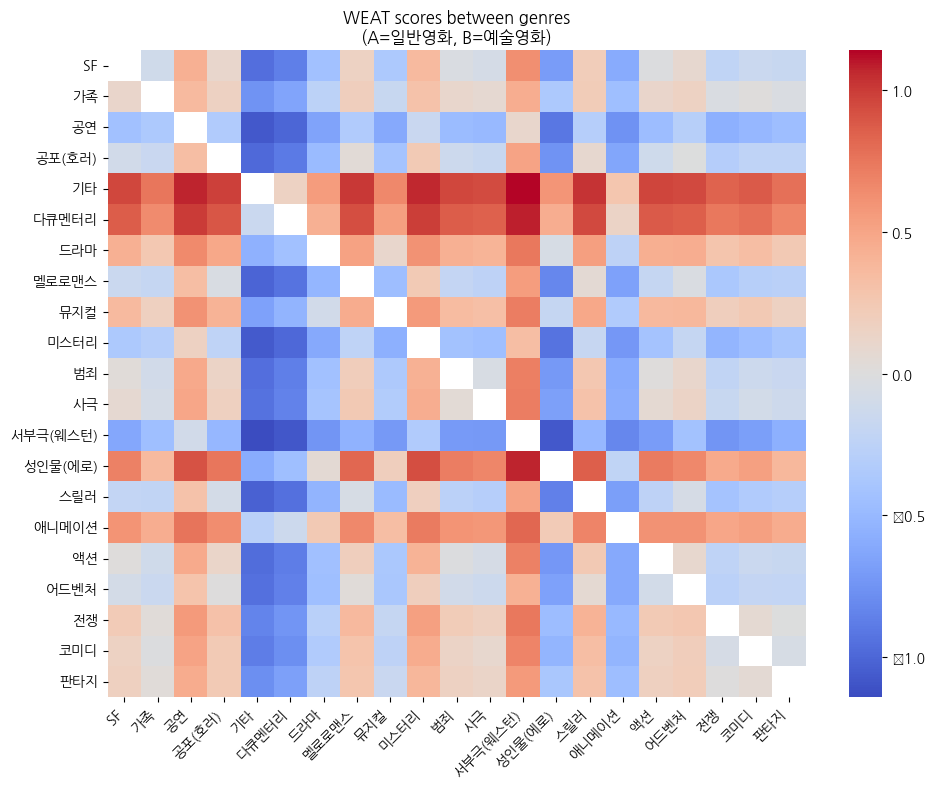

In [65]:
plt.figure(figsize=(10, 8))
sns.heatmap(weat_mat_df, annot=False, cmap='coolwarm', center=0)
plt.title("WEAT scores between genres\n(A=일반영화, B=예술영화)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# 실험 2

In [66]:
# --- type을 target으로 준비 ---
type_df = type   # 이미 load_file 한 DataFrame

type_names = type_df['name'].tolist()      # ['일반(상업) 영화', '예술 영화'] 같은 형태
type_vec_dicts = []

for _, row in type_df.iterrows():
    toks = row['vocab_set']
    vec_dict = tokens_to_vec_dict(toks, model)
    type_vec_dicts.append(vec_dict)

# 여기서는 target이 type이니까,
# X = type_vec_dicts[0], Y = type_vec_dicts[1] 이런 식으로 쓸 거야.

# --- genre를 attribute로 준비 ---
genre_df = genre
genre_names = genre_df['name'].tolist()
genre_vec_dicts = []

for _, row in genre_df.iterrows():
    toks = row['vocab_set']
    vec_dict = tokens_to_vec_dict(toks, model)
    genre_vec_dicts.append(vec_dict)


In [67]:
def build_weat_matrix_attr_genre(
    type_vec_dicts,
    type_names,
    genre_vec_dicts,
    genre_names,
    score_fn=weat_score,
    antisymmetric=True,
    diag_value=np.nan,
):
    """
    type_vec_dicts : list[dict[word]=vector]
        target 역할을 하는 type 임베딩 (보통 2개: 일반, 예술)

    type_names : list[str]
        type 이름 리스트 (길이 2라고 가정)

    genre_vec_dicts : list[dict[word]=vector]
        attribute 역할을 하는 genre 임베딩들

    genre_names : list[str]
        genre 이름 리스트

    antisymmetric : bool
        WEAT(X,Y|A,B) = -WEAT(X,Y|A,B)이므로
        M[j,i] = -M[i,j]로 채워서 연산 절반으로 줄일지 여부

    diag_value : float
        대각선(i==j)에 넣을 값 (보통 NaN)

    return: pandas.DataFrame (행/열 = genre_names)
            M[i,j] = WEAT(type_0, type_1 | genre_i, genre_j)
    """
    assert len(type_vec_dicts) == 2, "type(target)은 2개(예: 일반/예술)라고 가정합니다."

    X_dict = type_vec_dicts[0]  # 예: 일반 영화
    Y_dict = type_vec_dicts[1]  # 예: 예술 영화

    n = len(genre_vec_dicts)
    mat = np.zeros((n, n), dtype=float)

    for i in range(n):
        for j in range(n):
            if i == j:
                mat[i, j] = diag_value
                continue

            if antisymmetric and j < i:
                # 속성 A/B를 뒤집으면 WEAT 값 부호가 바뀜
                mat[i, j] = -mat[j, i]
                continue

            A_dict = genre_vec_dicts[i]  # attribute A = genre_i
            B_dict = genre_vec_dicts[j]  # attribute B = genre_j

            if len(X_dict) == 0 or len(Y_dict) == 0 or \
               len(A_dict) == 0 or len(B_dict) == 0:
                mat[i, j] = np.nan
                continue

            score = score_fn(X_dict, Y_dict, A_dict, B_dict)
            mat[i, j] = score

    weat_df = pd.DataFrame(mat, index=genre_names, columns=genre_names)
    return weat_df


In [68]:
weat_type_attr_genre = build_weat_matrix_attr_genre(
    type_vec_dicts=type_vec_dicts,
    type_names=type_names,
    genre_vec_dicts=genre_vec_dicts,
    genre_names=genre_names,
)

print(weat_type_attr_genre)


                SF        가족        공연    공포(호러)        기타     다큐멘터리  \
SF             NaN -0.103176  0.267430  0.077761 -0.924300 -0.771821   
가족        0.103176       NaN  0.344039  0.222322 -0.867967 -0.620539   
공연       -0.267430 -0.344039       NaN -0.236367 -1.092827 -0.954524   
공포(호러)   -0.077761 -0.222322  0.236367       NaN -0.916502 -0.717233   
기타        0.924300  0.867967  1.092827  0.916502       NaN  0.428300   
다큐멘터리     0.771821  0.620539  0.954524  0.717233 -0.428300       NaN   
드라마       0.552162  0.477281  0.901122  0.796778 -0.895216 -0.591941   
멜로로맨스    -0.072923 -0.226083  0.216310 -0.041305 -0.791328 -0.626991   
뮤지컬       0.307760  0.170128  0.777734  0.325623 -1.007517 -0.918784   
미스터리     -0.236475 -0.362595  0.099304 -0.800410 -0.967197 -0.771585   
범죄        0.018107 -0.124229  0.341670  0.239816 -0.926172 -0.708590   
사극        0.058889 -0.087892  0.521712  0.161362 -1.005738 -0.783513   
서부극(웨스턴) -0.504428 -0.554389 -0.081633 -0.434358 -1.184029 -1.00

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


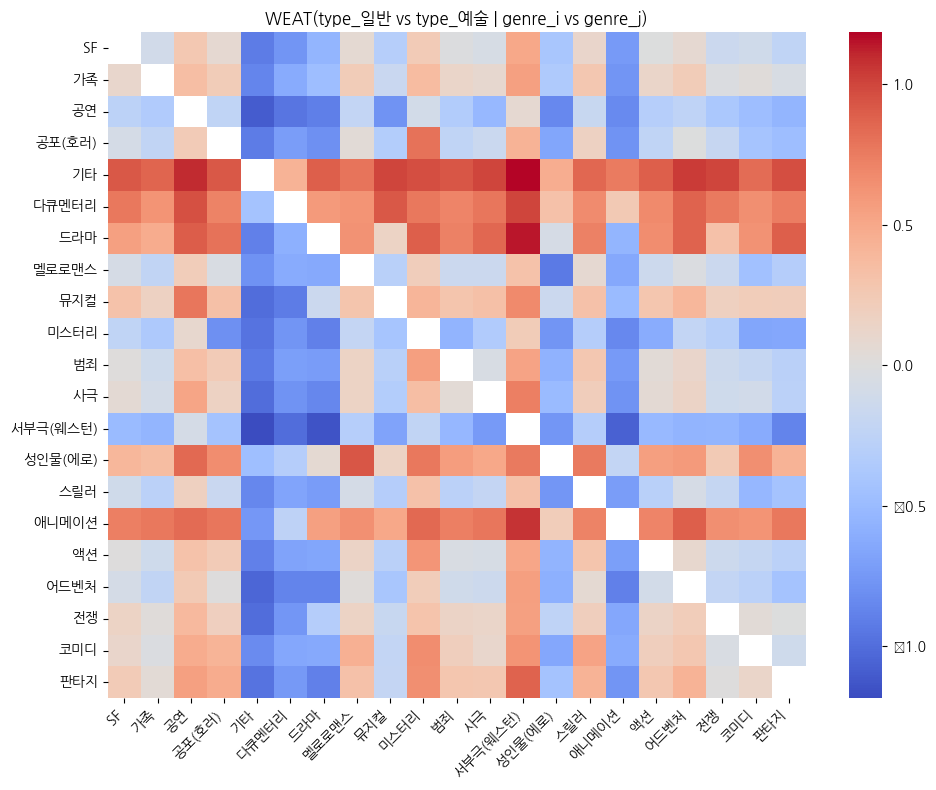

In [69]:
plt.figure(figsize=(10, 8))
sns.heatmap(weat_type_attr_genre, cmap="coolwarm", center=0)
plt.title("WEAT(type_일반 vs type_예술 | genre_i vs genre_j)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# 삽질 코드
- 개념을 정확히 이해 못해서 heatmap에 대한 해석 불가
- target을 genre로 했을 때 21\*21이 나왔으므로 target을 type으로 하면 2\*2가 나올 것이라 오해
- 정확히 말하면 다음과 같음.
    - X,Y가 장르일 때는 X, Y 조합의 개수가 210개 이므로 21\*21의 heatmap 1개 생성
    - X,Y가 타입일 때는 X,Y 조합의 개수가 1개 이므로 210개의 스칼라 값
    - 생성 X,Y가 타입일 때는 시각화를 A, B를 축으로 한 21\*21의 heatmap 1개 생성.

In [90]:
# from numpy.linalg import norm

# def cos_sim_matrix(X, Y):
#     X = np.asarray(X, dtype=float)
#     Y = np.asarray(Y, dtype=float)
#     X_norm = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
#     Y_norm = Y / (np.linalg.norm(Y, axis=1, keepdims=True) + 1e-12)
#     return np.dot(X_norm, Y_norm.T)

# def mean_assoc(target_vec_dict, attr_vec_dict):
#     """
#     target_vec_dict: {단어:벡터}
#     attr_vec_dict  : {단어:벡터}
#     → target 단어 전체 vs attr 단어 전체 코사인 유사도의 평균
#     """
#     if len(target_vec_dict) == 0 or len(attr_vec_dict) == 0:
#         return np.nan
#     T = np.stack(list(target_vec_dict.values()))   # (n_t, d)
#     A = np.stack(list(attr_vec_dict.values()))     # (n_a, d)
#     sims = cos_sim_matrix(T, A)                    # (n_t, n_a)
#     return sims.mean()

# def type_genre_2x2_matrix(
#     type_vec_dicts,
#     type_names,
#     genre_vec_dicts,
#     genre_names,
#     idx_g1,
#     idx_g2,
# ):
#     """
#     행: 타입(일반, 예술)
#     열: 장르(A,B)
#     값을 mean cosine similarity 로 채운 2×2 DataFrame 반환
#     """
#     A = genre_vec_dicts[idx_g1]  # 장르 A
#     B = genre_vec_dicts[idx_g2]  # 장르 B

#     M = np.zeros((2, 2))
#     for ti in range(2):
#         T = type_vec_dicts[ti]
#         M[ti, 0] = mean_assoc(T, A)  # 타입 ti ↔ 장르 A
#         M[ti, 1] = mean_assoc(T, B)  # 타입 ti ↔ 장르 B

#     df = pd.DataFrame(
#         M,
#         index=type_names,
#         columns=[genre_names[idx_g1], genre_names[idx_g2]]
#     )
#     return df


In [91]:
# def plot_2x2_heatmap(df_2x2, pair_idx=None, total_pairs=None):
#     plt.figure(figsize=(4, 3))
#     sns.heatmap(df_2x2, annot=True, fmt=".3f", cmap="coolwarm", vmin=-1, vmax=1)
#     title = "Type–Genre Association (cosine mean)"
#     if pair_idx is not None and total_pairs is not None:
#         title += f"\npair {pair_idx}/{total_pairs}"
#     plt.title(title)
#     plt.xticks(rotation=45, ha='right')
#     plt.yticks(rotation=0)
#     plt.tight_layout()
#     plt.show()


In [94]:
# def weat_score(target_X, target_Y, attribute_A, attribute_B):
#     X = np.array(list(target_X.values()))
#     Y = np.array(list(target_Y.values()))
#     A = np.array(list(attribute_A.values()))
#     B = np.array(list(attribute_B.values()))

#     s_X = s(X, A, B)
#     s_Y = s(Y, A, B)

#     mean_X = np.mean(s_X)
#     mean_Y = np.mean(s_Y)

#     std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
#     if std_dev == 0:
#         return np.nan

#     return (mean_X - mean_Y) / std_dev

# def s(W, A, B):
#     c_a = cos_sim_matrix(W, A)
#     c_b = cos_sim_matrix(W, B)
#     return np.mean(c_a, axis=1) - np.mean(c_b, axis=1)


In [92]:
# from itertools import combinations

# def plot_all_type_genre_2x2_matrices(
#     type_vec_dicts,
#     type_names,
#     genre_vec_dicts,
#     genre_names,
#     max_pairs=None,   # 디버깅할 때 5개만 보고 싶으면 숫자 넣기
# ):
#     idx_pairs = list(combinations(range(len(genre_names)), 2))
#     total_pairs = len(idx_pairs)

#     if max_pairs is not None:
#         idx_pairs = idx_pairs[:max_pairs]
#         total_pairs = len(idx_pairs)

#     print(f"총 장르 페어 수: {total_pairs}")

#     for k, (i, j) in enumerate(idx_pairs, start=1):
#         g1 = genre_names[i]
#         g2 = genre_names[j]
#         print(f"\n[{k}/{total_pairs}] 장르 페어: {g1} vs {g2}")

#         df_2x2 = type_genre_2x2_matrix(
#             type_vec_dicts=type_vec_dicts,
#             type_names=type_names,
#             genre_vec_dicts=genre_vec_dicts,
#             genre_names=genre_names,
#             idx_g1=i,
#             idx_g2=j,
#         )
#         print(df_2x2)  # 숫자도 같이 보고 싶으면 유지, 필요 없으면 삭제

#         plot_2x2_heatmap(df_2x2, pair_idx=k, total_pairs=total_pairs)


총 장르 페어 수: 210

[1/210] 장르 페어: SF vs 가족
                 SF        가족
일반(상업) 영화  0.294834  0.300165
예술 영화      0.295641  0.295585


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


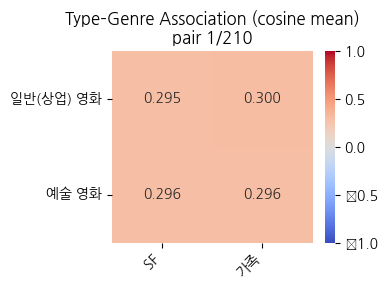


[2/210] 장르 페어: SF vs 공연
                 SF        공연
일반(상업) 영화  0.294834  0.293465
예술 영화      0.295641  0.307797


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)



[3/210] 장르 페어: SF vs 공포(호러)
                 SF    공포(호러)
일반(상업) 영화  0.294834  0.295422
예술 영화      0.295641  0.298936


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)



[4/210] 장르 페어: SF vs 기타
                 SF        기타
일반(상업) 영화  0.294834  0.361974
예술 영화      0.295641  0.300252


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


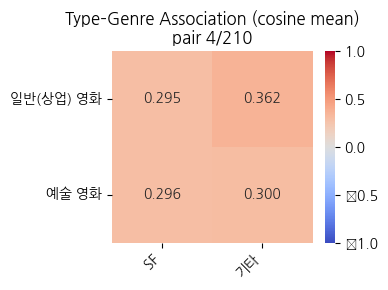


[5/210] 장르 페어: SF vs 다큐멘터리
                 SF     다큐멘터리
일반(상업) 영화  0.294834  0.345137
예술 영화      0.295641  0.294863


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)



[6/210] 장르 페어: SF vs 드라마
                 SF       드라마
일반(상업) 영화  0.294834  0.327143
예술 영화      0.295641  0.306433


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


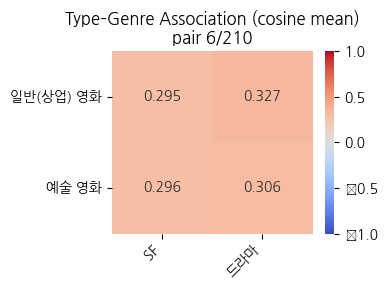


[7/210] 장르 페어: SF vs 멜로로맨스
                 SF     멜로로맨스
일반(상업) 영화  0.294834  0.301232
예술 영화      0.295641  0.305730


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


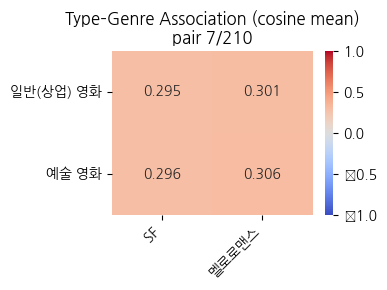


[8/210] 장르 페어: SF vs 뮤지컬
                 SF       뮤지컬
일반(상업) 영화  0.294834  0.333082
예술 영화      0.295641  0.318229


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


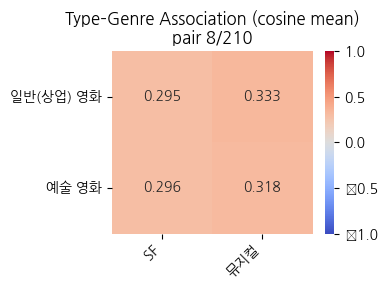


[9/210] 장르 페어: SF vs 미스터리
                 SF      미스터리
일반(상업) 영화  0.294834  0.286110
예술 영화      0.295641  0.295694


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


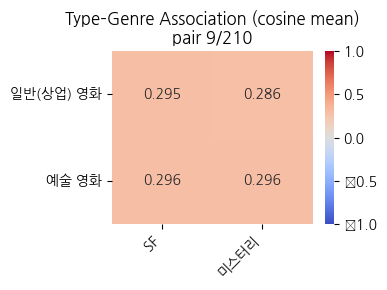


[10/210] 장르 페어: SF vs 범죄
                 SF        범죄
일반(상업) 영화  0.294834  0.267784
예술 영화      0.295641  0.267946


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


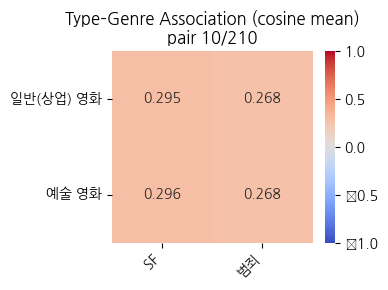


[11/210] 장르 페어: SF vs 사극
                 SF        사극
일반(상업) 영화  0.294834  0.321973
예술 영화      0.295641  0.320990


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)



[12/210] 장르 페어: SF vs 서부극(웨스턴)
                 SF  서부극(웨스턴)
일반(상업) 영화  0.294834  0.315128
예술 영화      0.295641  0.332507


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


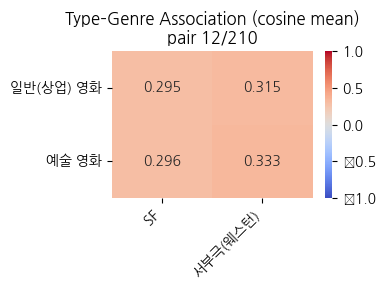


[13/210] 장르 페어: SF vs 성인물(에로)
                 SF   성인물(에로)
일반(상업) 영화  0.294834  0.306314
예술 영화      0.295641  0.282446


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)



[14/210] 장르 페어: SF vs 스릴러
                 SF       스릴러
일반(상업) 영화  0.294834  0.288264
예술 영화      0.295641  0.293874


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


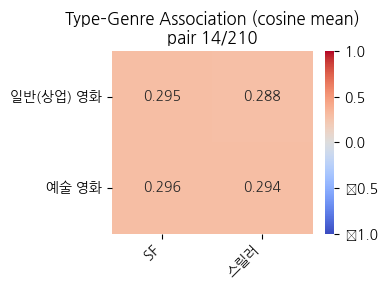


[15/210] 장르 페어: SF vs 애니메이션
                 SF     애니메이션
일반(상업) 영화  0.294834  0.332327
예술 영화      0.295641  0.292993


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)



[16/210] 장르 페어: SF vs 액션
                 SF        액션
일반(상업) 영화  0.294834  0.280900
예술 영화      0.295641  0.281425


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)



[17/210] 장르 페어: SF vs 어드벤처
                 SF      어드벤처
일반(상업) 영화  0.294834  0.276604
예술 영화      0.295641  0.280081


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


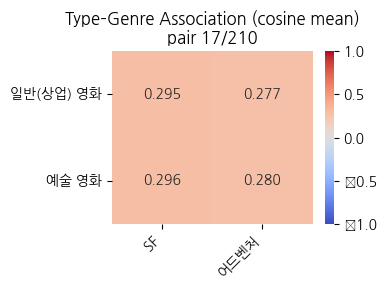


[18/210] 장르 페어: SF vs 전쟁
                 SF        전쟁
일반(상업) 영화  0.294834  0.248040
예술 영화      0.295641  0.241814


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


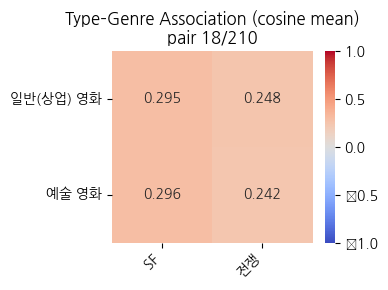


[19/210] 장르 페어: SF vs 코미디
                 SF       코미디
일반(상업) 영화  0.294834  0.309106
예술 영화      0.295641  0.305303


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


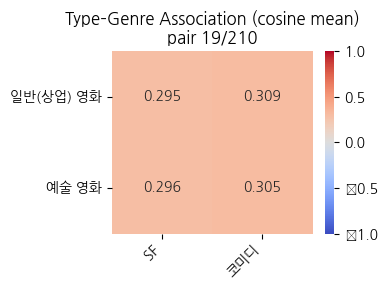


[20/210] 장르 페어: SF vs 판타지
                 SF       판타지
일반(상업) 영화  0.294834  0.313123
예술 영화      0.295641  0.306866


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


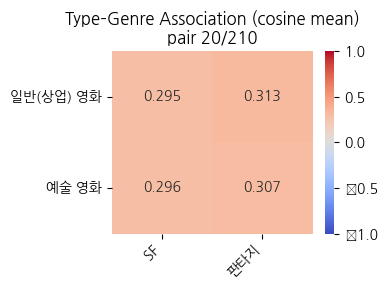


[21/210] 장르 페어: 가족 vs 공연
                 가족        공연
일반(상업) 영화  0.300165  0.293465
예술 영화      0.295585  0.307797


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)



[22/210] 장르 페어: 가족 vs 공포(호러)
                 가족    공포(호러)
일반(상업) 영화  0.300165  0.295422
예술 영화      0.295585  0.298936


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)



[23/210] 장르 페어: 가족 vs 기타
                 가족        기타
일반(상업) 영화  0.300165  0.361974
예술 영화      0.295585  0.300252


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


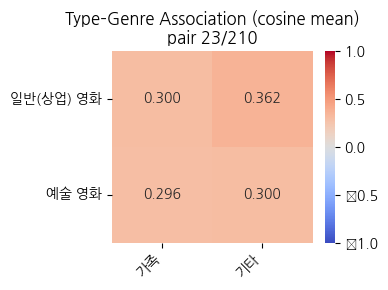


[24/210] 장르 페어: 가족 vs 다큐멘터리
                 가족     다큐멘터리
일반(상업) 영화  0.300165  0.345137
예술 영화      0.295585  0.294863


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


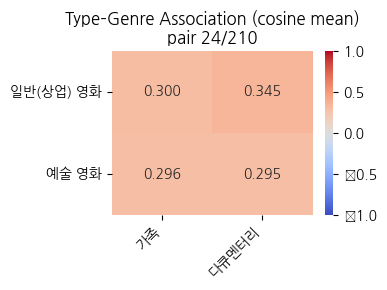


[25/210] 장르 페어: 가족 vs 드라마
                 가족       드라마
일반(상업) 영화  0.300165  0.327143
예술 영화      0.295585  0.306433


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


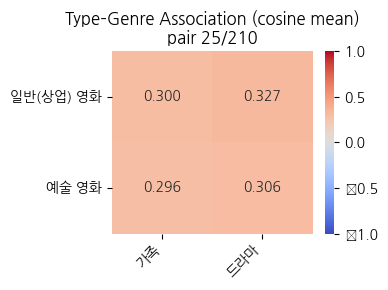


[26/210] 장르 페어: 가족 vs 멜로로맨스
                 가족     멜로로맨스
일반(상업) 영화  0.300165  0.301232
예술 영화      0.295585  0.305730


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


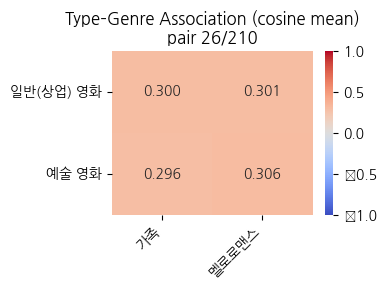


[27/210] 장르 페어: 가족 vs 뮤지컬
                 가족       뮤지컬
일반(상업) 영화  0.300165  0.333082
예술 영화      0.295585  0.318229


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


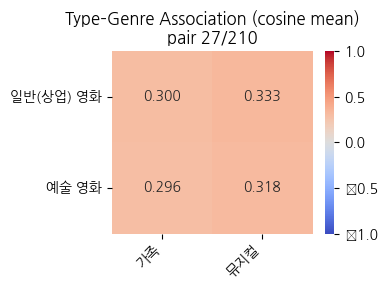


[28/210] 장르 페어: 가족 vs 미스터리
                 가족      미스터리
일반(상업) 영화  0.300165  0.286110
예술 영화      0.295585  0.295694


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)



[29/210] 장르 페어: 가족 vs 범죄
                 가족        범죄
일반(상업) 영화  0.300165  0.267784
예술 영화      0.295585  0.267946


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


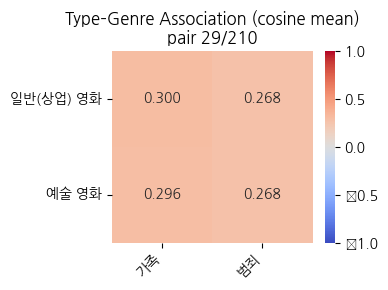


[30/210] 장르 페어: 가족 vs 사극
                 가족        사극
일반(상업) 영화  0.300165  0.321973
예술 영화      0.295585  0.320990


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)



[31/210] 장르 페어: 가족 vs 서부극(웨스턴)
                 가족  서부극(웨스턴)
일반(상업) 영화  0.300165  0.315128
예술 영화      0.295585  0.332507


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


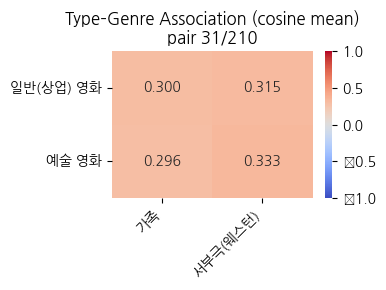


[32/210] 장르 페어: 가족 vs 성인물(에로)
                 가족   성인물(에로)
일반(상업) 영화  0.300165  0.306314
예술 영화      0.295585  0.282446


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


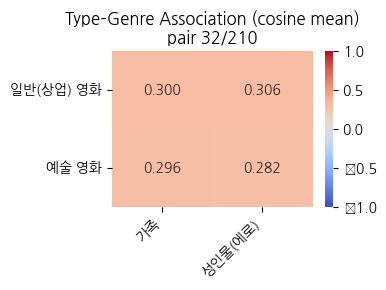


[33/210] 장르 페어: 가족 vs 스릴러
                 가족       스릴러
일반(상업) 영화  0.300165  0.288264
예술 영화      0.295585  0.293874


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


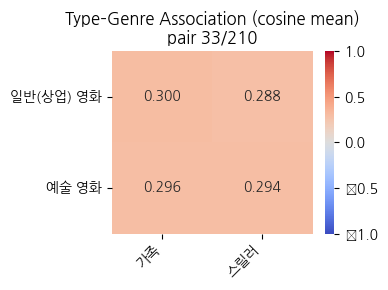


[34/210] 장르 페어: 가족 vs 애니메이션
                 가족     애니메이션
일반(상업) 영화  0.300165  0.332327
예술 영화      0.295585  0.292993


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


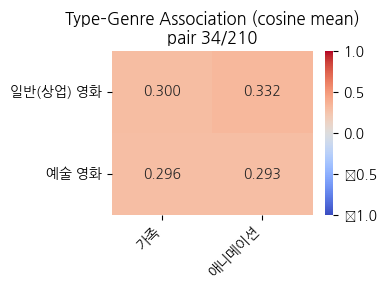


[35/210] 장르 페어: 가족 vs 액션
                 가족        액션
일반(상업) 영화  0.300165  0.280900
예술 영화      0.295585  0.281425


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


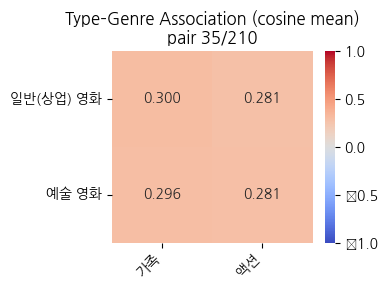


[36/210] 장르 페어: 가족 vs 어드벤처
                 가족      어드벤처
일반(상업) 영화  0.300165  0.276604
예술 영화      0.295585  0.280081


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


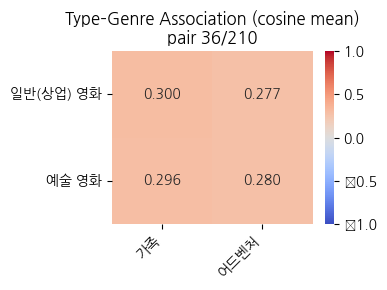


[37/210] 장르 페어: 가족 vs 전쟁
                 가족        전쟁
일반(상업) 영화  0.300165  0.248040
예술 영화      0.295585  0.241814


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


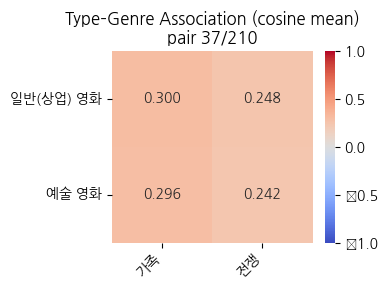


[38/210] 장르 페어: 가족 vs 코미디
                 가족       코미디
일반(상업) 영화  0.300165  0.309106
예술 영화      0.295585  0.305303


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


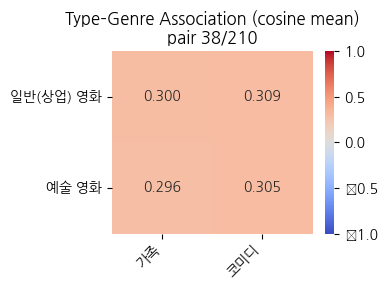


[39/210] 장르 페어: 가족 vs 판타지
                 가족       판타지
일반(상업) 영화  0.300165  0.313123
예술 영화      0.295585  0.306866


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


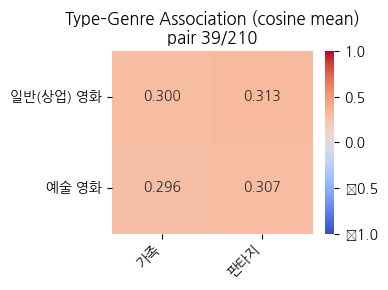


[40/210] 장르 페어: 공연 vs 공포(호러)
                 공연    공포(호러)
일반(상업) 영화  0.293465  0.295422
예술 영화      0.307797  0.298936


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


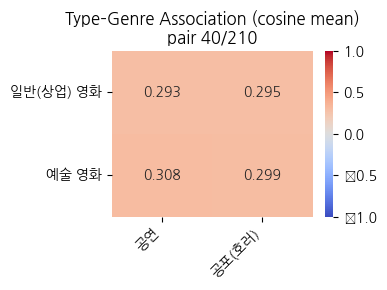

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()



[41/210] 장르 페어: 공연 vs 기타
                 공연        기타
일반(상업) 영화  0.293465  0.361974
예술 영화      0.307797  0.300252


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


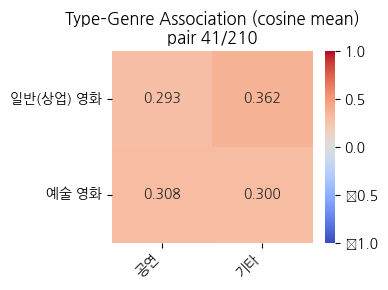

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()



[42/210] 장르 페어: 공연 vs 다큐멘터리
                 공연     다큐멘터리
일반(상업) 영화  0.293465  0.345137
예술 영화      0.307797  0.294863


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


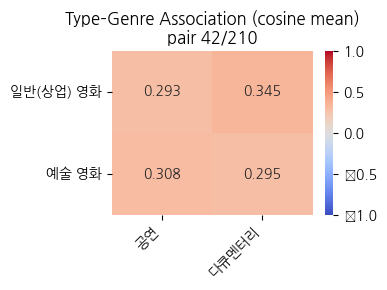

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()



[43/210] 장르 페어: 공연 vs 드라마
                 공연       드라마
일반(상업) 영화  0.293465  0.327143
예술 영화      0.307797  0.306433


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


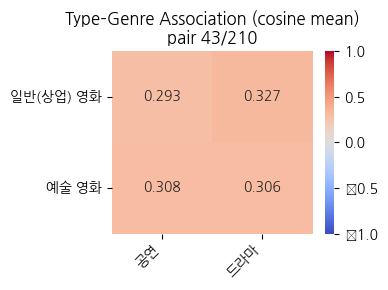

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()



[44/210] 장르 페어: 공연 vs 멜로로맨스
                 공연     멜로로맨스
일반(상업) 영화  0.293465  0.301232
예술 영화      0.307797  0.305730


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()



[45/210] 장르 페어: 공연 vs 뮤지컬
                 공연       뮤지컬
일반(상업) 영화  0.293465  0.333082
예술 영화      0.307797  0.318229


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


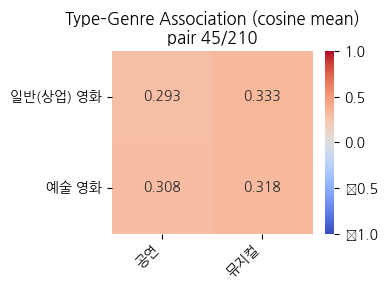

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()



[46/210] 장르 페어: 공연 vs 미스터리
                 공연      미스터리
일반(상업) 영화  0.293465  0.286110
예술 영화      0.307797  0.295694


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()



[47/210] 장르 페어: 공연 vs 범죄
                 공연        범죄
일반(상업) 영화  0.293465  0.267784
예술 영화      0.307797  0.267946


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


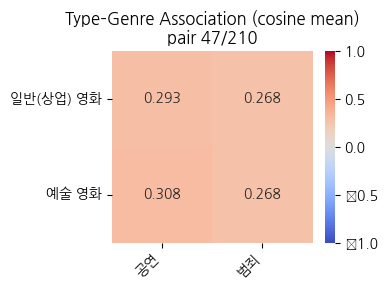

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()



[48/210] 장르 페어: 공연 vs 사극
                 공연        사극
일반(상업) 영화  0.293465  0.321973
예술 영화      0.307797  0.320990


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


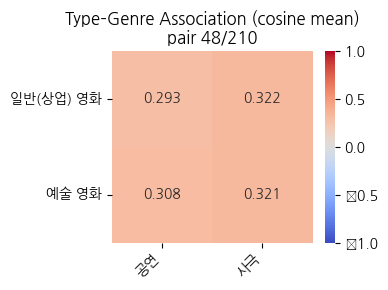

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()



[49/210] 장르 페어: 공연 vs 서부극(웨스턴)
                 공연  서부극(웨스턴)
일반(상업) 영화  0.293465  0.315128
예술 영화      0.307797  0.332507


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()



[50/210] 장르 페어: 공연 vs 성인물(에로)
                 공연   성인물(에로)
일반(상업) 영화  0.293465  0.306314
예술 영화      0.307797  0.282446


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


KeyboardInterrupt: 

In [93]:
# # 진짜 210개 전부 보려면:
# plot_all_type_genre_2x2_matrices(
#     type_vec_dicts=type_vec_dicts,
#     type_names=type_names,
#     genre_vec_dicts=genre_vec_dicts,
#     genre_names=genre_names,
#     max_pairs=None,   # ← None 이면 210개 전부
# )


# 실험 3

In [70]:
import numpy as np
from numpy.linalg import norm

def cos_sim_matrix(X, Y):
    """
    X: (n_x, d)
    Y: (n_y, d)
    return: (n_x, n_y) 코사인 유사도 행렬
    """
    X = np.asarray(X, dtype=float)
    Y = np.asarray(Y, dtype=float)

    X_norm = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
    Y_norm = Y / (np.linalg.norm(Y, axis=1, keepdims=True) + 1e-12)

    return np.dot(X_norm, Y_norm.T)


def s(W, A, B):
    """
    W: (n_w, d)
    A: (n_a, d)
    B: (n_b, d)

    각 w에 대해 mean cos(w,A) - mean cos(w,B) 계산
    return: (n_w,) 배열
    """
    c_a = cos_sim_matrix(W, A)   # (n_w, n_a)
    c_b = cos_sim_matrix(W, B)   # (n_w, n_b)

    mean_A = np.mean(c_a, axis=1)
    mean_B = np.mean(c_b, axis=1)

    return mean_A - mean_B


def weat_score(target_X, target_Y, attribute_A, attribute_B):
    """
    target_X, target_Y, attribute_A, attribute_B:
      dict[word] = vector
    """
    X = np.array(list(target_X.values()))
    Y = np.array(list(target_Y.values()))
    A = np.array(list(attribute_A.values()))
    B = np.array(list(attribute_B.values()))

    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)

    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    if std_dev == 0:
        return np.nan

    return (mean_X - mean_Y) / std_dev


In [71]:
import pandas as pd

def build_weat_matrix(
    target_vec_dicts,
    target_names,
    attr_A_vec,
    attr_B_vec,
    score_fn=weat_score,
    symmetric=True,
    diag_value=np.nan,
):
    """
    target_vec_dicts : list[dict[str, np.ndarray]]
    target_names     : list[str]
    attr_A_vec, attr_B_vec : dict[str, np.ndarray]

    return: 행/열이 target_names 인 WEAT 점수 DataFrame
    """
    n = len(target_vec_dicts)
    mat = np.zeros((n, n), dtype=float)

    for i in range(n):
        for j in range(n):
            if i == j:
                mat[i, j] = diag_value
                continue

            if symmetric and j < i:
                mat[i, j] = -mat[j, i]
                continue

            X_dict = target_vec_dicts[i]
            Y_dict = target_vec_dicts[j]

            if len(X_dict) == 0 or len(Y_dict) == 0 or \
               len(attr_A_vec) == 0 or len(attr_B_vec) == 0:
                mat[i, j] = np.nan
                continue

            score = score_fn(X_dict, Y_dict, attr_A_vec, attr_B_vec)
            mat[i, j] = score

    weat_df = pd.DataFrame(mat, index=target_names, columns=target_names)
    return weat_df


In [72]:
def build_genre_as_target_and_attribute_matrix(
    genre_df,
    model,
    attr_A_name,
    attr_B_name,
    symmetric=True,
    diag_value=np.nan,
):
    """
    genre_df: ['name', 'vocab_set'] 컬럼을 가진 DataFrame
    model: gensim Word2Vec
    attr_A_name, attr_B_name: attribute로 쓸 장르 이름 (둘 다 genre_df['name'] 안에 있어야 함)

    return: WEAT(genre_i, genre_j | genre_A, genre_B) 장르×장르 매트릭스
    """
    # 1) 장르별 vec dict 준비
    genre_names = genre_df['name'].tolist()
    genre_vec_dicts = []
    for _, row in genre_df.iterrows():
        toks = row['vocab_set']
        vec_dict = tokens_to_vec_dict(toks, model)
        genre_vec_dicts.append(vec_dict)

    # 2) attribute로 사용할 A/B 장르 찾기
    try:
        idx_A = genre_names.index(attr_A_name)
        idx_B = genre_names.index(attr_B_name)
    except ValueError as e:
        raise ValueError(f"attr_A_name/attr_B_name이 genre_df['name']에 없습니다: {e}")

    attr_A_vec = genre_vec_dicts[idx_A]
    attr_B_vec = genre_vec_dicts[idx_B]

    # 3) target = 모든 장르, attribute = (특정 두 장르 A/B)
    weat_df = build_weat_matrix(
        target_vec_dicts=genre_vec_dicts,
        target_names=genre_names,
        attr_A_vec=attr_A_vec,
        attr_B_vec=attr_B_vec,
        symmetric=symmetric,
        diag_value=diag_value,
    )
    return weat_df


In [88]:
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def run_weat_for_all_genre_pairs(
    genre_df,
    model,
    max_pairs=None,
    symmetric=True,
    diag_value=np.nan,
):
    """
    genre_df : ['name', 'vocab_set']를 가진 DataFrame
    model    : gensim Word2Vec
    max_pairs: attribute (A,B) 페어 개수를 제한하고 싶을 때 (None이면 전부)
    symmetric: WEAT(X,Y|A,B) ≈ -WEAT(Y,X|A,B) 가정하여 (i,j)/(j,i) 대칭 사용 여부
    diag_value: i == j (자기 자신)일 때 넣을 값 (보통 np.nan)

    동작:
      - 모든 장르 이름들로부터 attribute 페어 (A,B)를 만들고
      - 각 (A,B)에 대해 WEAT(genre_i, genre_j | A,B) 매트릭스를 계산
      - 단, X=genre_i, Y=genre_j가 A,B와 겹치는 경우(i 또는 j가 A/B이면)에는
        WEAT을 계산하지 않고 NaN으로 둔다.
    """
    genre_names = genre_df['name'].tolist()
    n = len(genre_names)

    # 미리 장르별 vec dict 생성
    genre_vec_dicts = []
    for _, row in genre_df.iterrows():
        tokens = row['vocab_set']
        vec_dict = {w: model.wv[w] for w in tokens if w in model.wv}
        genre_vec_dicts.append(vec_dict)

    # 1) 장르 이름들로 가능한 (A,B) 페어를 전부 생성 (조합, 순서 없는 쌍)
    all_pairs = list(combinations(genre_names, 2))  # [('드라마','코미디'), ('드라마','범죄'), ...]
    if max_pairs is not None:
        all_pairs = all_pairs[:max_pairs]

    print(f"총 attribute 페어 개수: {len(all_pairs)}")

    weat_results = {}  # key: (A,B), value: DataFrame

    # 2) 각 (A,B) 페어에 대해 WEAT(genre_i, genre_j | A, B) 계산
    for attr_A_name, attr_B_name in all_pairs:
        print(f"\n=== A = {attr_A_name}, B = {attr_B_name} ===")

        # A, B 인덱스 찾기
        try:
            idx_A = genre_names.index(attr_A_name)
            idx_B = genre_names.index(attr_B_name)
        except ValueError as e:
            print(f"⚠ '{attr_A_name}' 또는 '{attr_B_name}'가 genre_df['name']에 없습니다: {e}")
            continue

        A_vec = genre_vec_dicts[idx_A]
        B_vec = genre_vec_dicts[idx_B]

        # attribute 쪽에 벡터가 하나도 없으면 스킵
        if len(A_vec) == 0 or len(B_vec) == 0:
            print("⚠ A 또는 B에 해당하는 단어 벡터가 없습니다. 이 페어는 건너뜁니다.")
            continue

        mat = np.zeros((n, n), dtype=float)

        for i in range(n):
            for j in range(n):
                # 자기 자신
                if i == j:
                    mat[i, j] = diag_value
                    continue

                # X 또는 Y가 A/B와 같으면 계산하지 않음 → NaN
                if i in (idx_A, idx_B) or j in (idx_A, idx_B):
                    mat[i, j] = np.nan
                    continue

                # 대칭 최적화: (j,i)는 -(i,j)로 채움
                if symmetric and j < i:
                    mat[i, j] = -mat[j, i]
                    continue

                X_dict = genre_vec_dicts[i]
                Y_dict = genre_vec_dicts[j]

                if len(X_dict) == 0 or len(Y_dict) == 0:
                    mat[i, j] = np.nan
                    continue

                score = weat_score(X_dict, Y_dict, A_vec, B_vec)
                mat[i, j] = score

        weat_mat = pd.DataFrame(mat, index=genre_names, columns=genre_names)
        weat_results[(attr_A_name, attr_B_name)] = weat_mat

        # 3) 히트맵 시각화
        plt.figure(figsize=(10, 8))
        sns.heatmap(weat_mat, cmap="coolwarm", center=0)
        plt.title(f"WEAT(genre_i, genre_j | {attr_A_name}, {attr_B_name})")
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    return weat_results

총 attribute 페어 개수: 10

=== A = SF, B = 가족 ===


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)



=== A = SF, B = 공연 ===


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


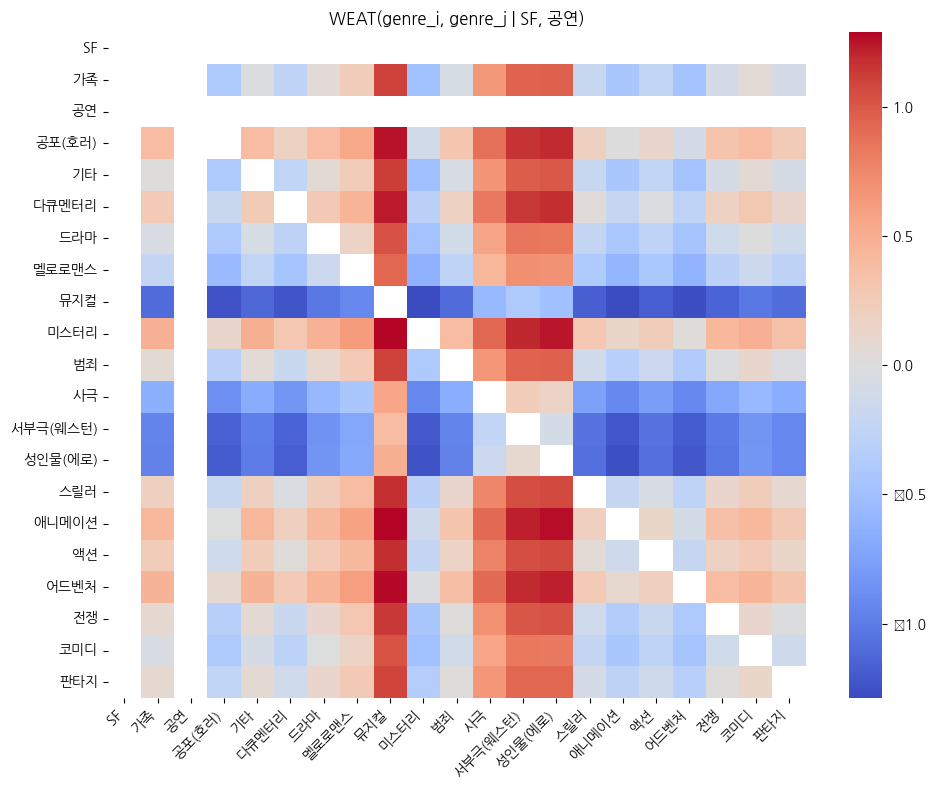


=== A = SF, B = 공포(호러) ===


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)



=== A = SF, B = 기타 ===


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


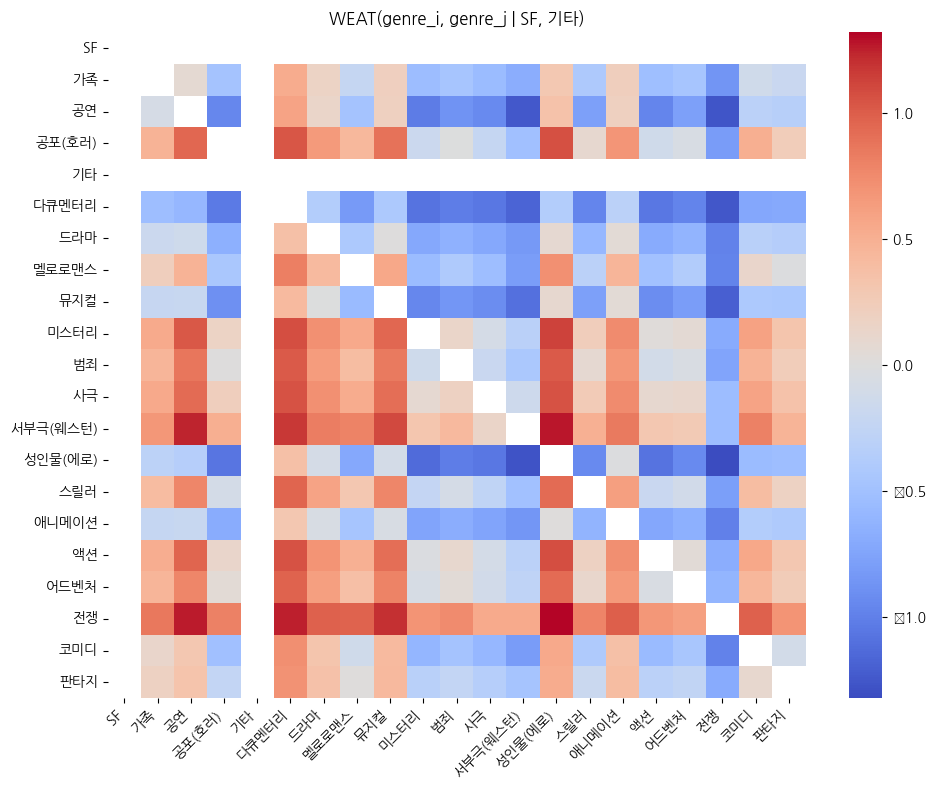


=== A = SF, B = 다큐멘터리 ===


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)



=== A = SF, B = 드라마 ===


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)



=== A = SF, B = 멜로로맨스 ===


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)



=== A = SF, B = 뮤지컬 ===


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


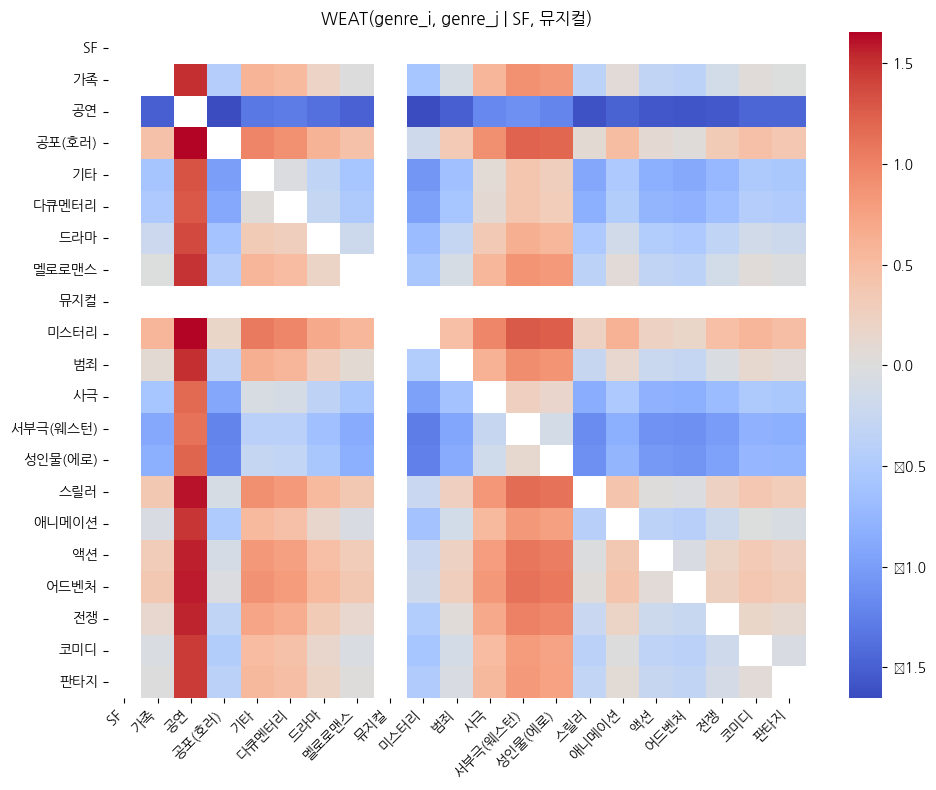


=== A = SF, B = 미스터리 ===


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


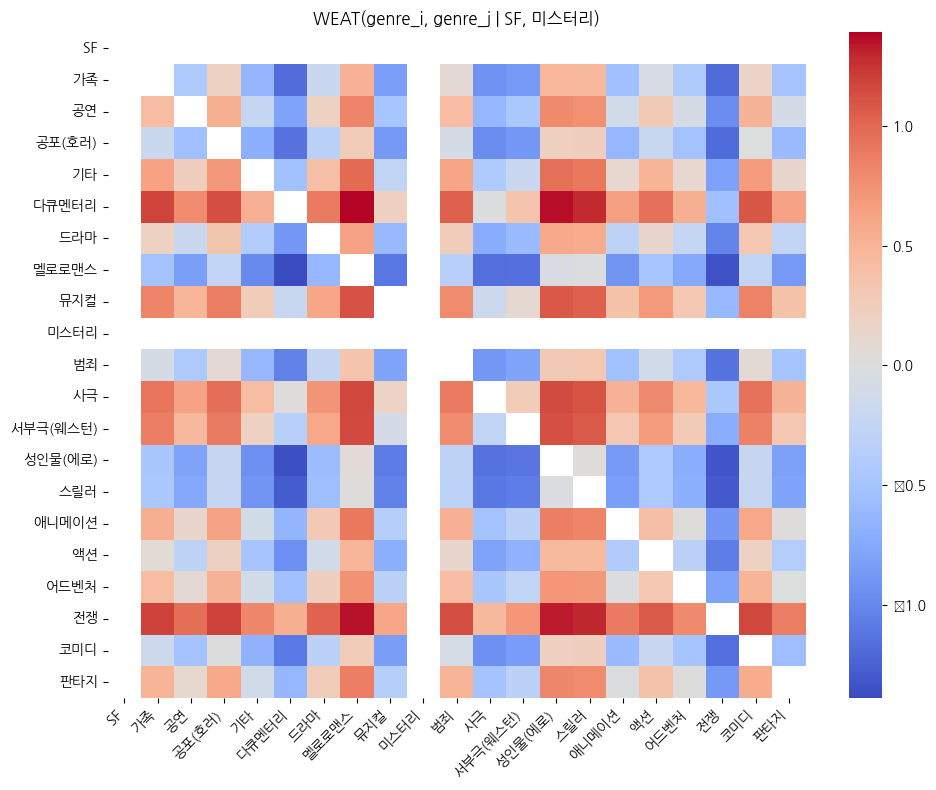


=== A = SF, B = 범죄 ===


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


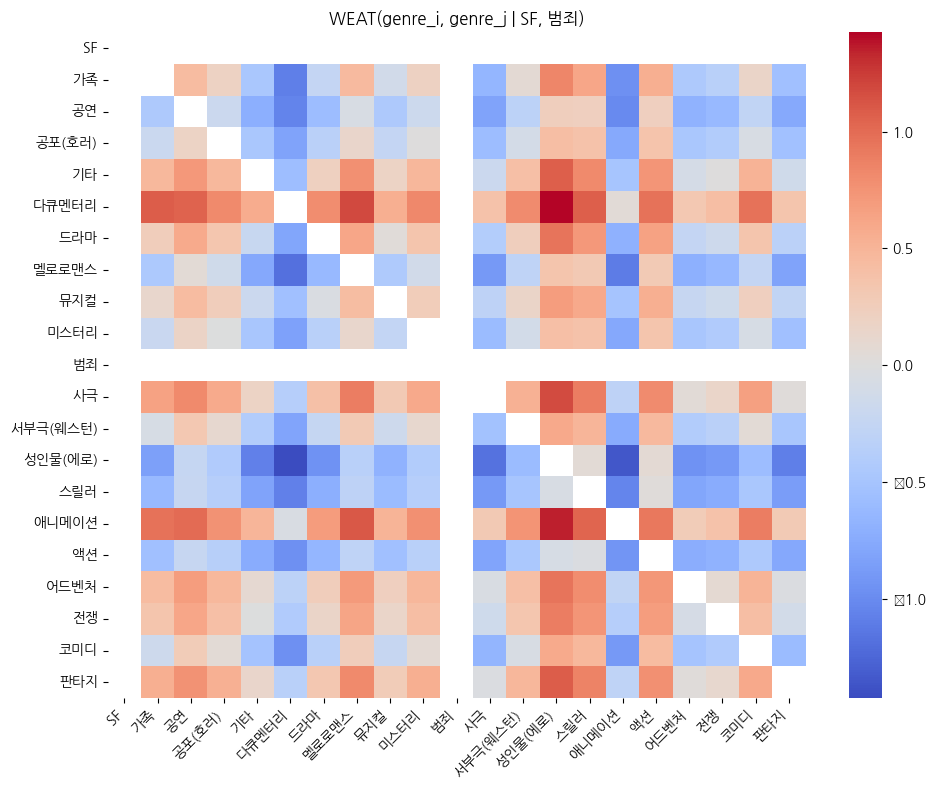

In [89]:
# genre: ['name', 'vocab_set'] DF (vocab_set는 이미 리스트 복원 완료라고 가정)
# model: 학습된 Word2Vec

# 모든 장르 페어에 대해 돌리고 싶으면:
weat_results = run_weat_for_all_genre_pairs(
    genre_df=genre,
    model=model,
    max_pairs=None,   # 또는 10처럼 제한할 수도 있음
    symmetric=True,
    diag_value=np.nan,
)


# TSNE 시각화

In [95]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

def tsne_plot_genre_words(genre_df, model, max_words_per_genre=20, random_state=42):
    """
    genre_df: columns ['name', 'vocab_set']
    model: gensim Word2Vec
    max_words_per_genre: 장르당 최대 단어 수 (너무 많으면 그림이 복잡해짐)
    """
    all_vectors = []
    all_labels = []
    all_genres = []

    for _, row in genre_df.iterrows():
        genre_name = row['name']
        tokens = row['vocab_set']

        # word2vec에 존재하는 단어만 선택
        valid_tokens = [w for w in tokens if w in model.wv]

        # 장르별 최대 N개만 사용 (랜덤 샘플링)
        if len(valid_tokens) > max_words_per_genre:
            valid_tokens = np.random.choice(valid_tokens, size=max_words_per_genre, replace=False)

        for w in valid_tokens:
            all_vectors.append(model.wv[w])
            all_labels.append(w)
            all_genres.append(genre_name)

    all_vectors = np.array(all_vectors)

    # t-SNE 수행
    tsne = TSNE(n_components=2, random_state=random_state, perplexity=30, init='random')
    embedded = tsne.fit_transform(all_vectors)

    # 장르별로 색/마커 다르게 그리기
    plt.figure(figsize=(10, 8))
    unique_genres = list(sorted(set(all_genres)))

    # 간단하게 장르별로 한 번씩 scatter
    for g in unique_genres:
        idx = [i for i, gg in enumerate(all_genres) if gg == g]
        plt.scatter(embedded[idx, 0], embedded[idx, 1], label=g, alpha=0.7, s=30)

    plt.title("t-SNE of Genre Word Embeddings")
    plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return embedded, all_labels, all_genres


/tmp/ipython-input-654548018.py:48: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


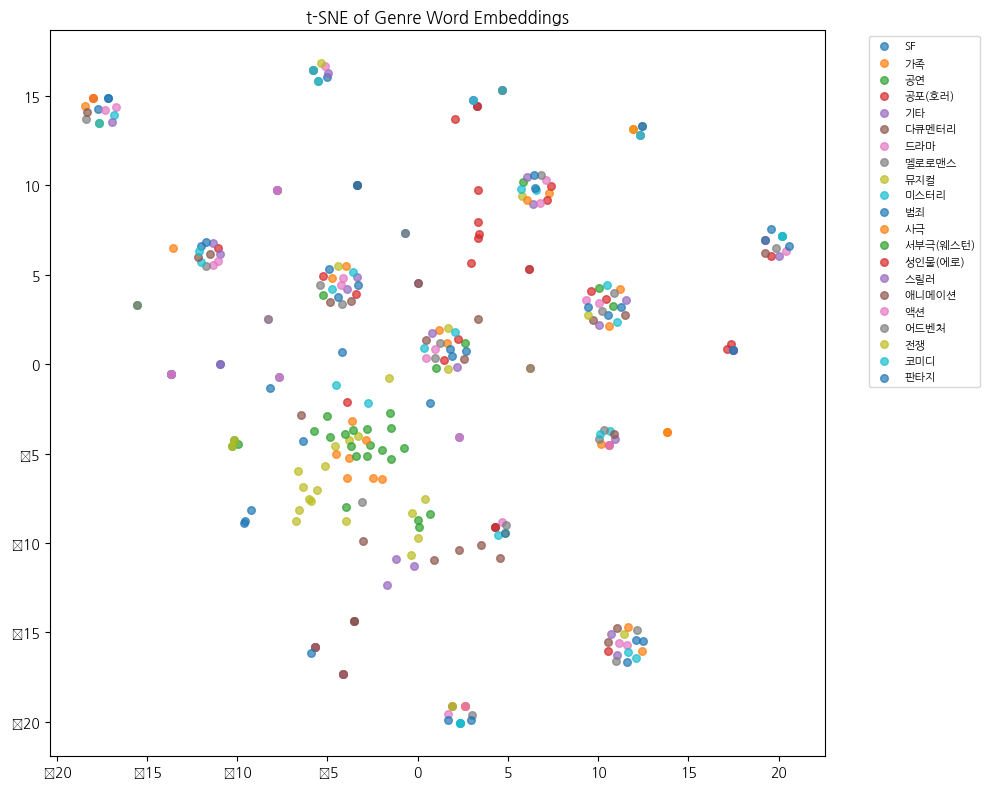

In [96]:
# genre: load_file('genre', 15) 후 restore_list까지 끝난 상태라고 가정
embedded_words, word_labels, word_genres = tsne_plot_genre_words(genre, model, max_words_per_genre=15)


In [97]:
def compute_genre_centroids(genre_df, model):
    """
    genre_df: ['name', 'vocab_set']
    return:
      centroids: (n_genre, d) array
      names:     장르 이름 리스트
    """
    centroids = []
    names = []

    for _, row in genre_df.iterrows():
        genre_name = row['name']
        tokens = row['vocab_set']

        vecs = [model.wv[w] for w in tokens if w in model.wv]
        if len(vecs) == 0:
            continue

        centroid = np.mean(vecs, axis=0)
        centroids.append(centroid)
        names.append(genre_name)

    return np.array(centroids), names


def tsne_plot_genre_centroids(genre_df, model, random_state=42):
    centroids, names = compute_genre_centroids(genre_df, model)

    tsne = TSNE(n_components=2, random_state=random_state, perplexity=5, init='random')
    embedded = tsne.fit_transform(centroids)

    plt.figure(figsize=(8, 6))
    plt.scatter(embedded[:, 0], embedded[:, 1])

    for i, name in enumerate(names):
        plt.text(embedded[i, 0], embedded[i, 1], name, fontsize=9)

    plt.title("t-SNE of Genre Centroids")
    plt.tight_layout()
    plt.show()

    return embedded, names


In [98]:
embedded_centroids, centroid_names = tsne_plot_genre_centroids(genre, model)


/tmp/ipython-input-1187611688.py:39: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


In [99]:
def compute_type_centroids(type_df, model):
    centroids = []
    names = []

    for _, row in type_df.iterrows():
        t_name = row['name']
        tokens = row['vocab_set']

        vecs = [model.wv[w] for w in tokens if w in model.wv]
        if len(vecs) == 0:
            continue

        centroid = np.mean(vecs, axis=0)
        centroids.append(vecs)
        names.append(t_name)

    return np.array(centroids), names


In [100]:
def tsne_plot_genre_and_type_centroids(genre_df, type_df, model, random_state=42):
    g_centroids, g_names = compute_genre_centroids(genre_df, model)
    t_centroids, t_names = compute_genre_centroids(type_df, model)  # 구조 동일

    all_centroids = np.vstack([g_centroids, t_centroids])
    all_names = g_names + t_names
    all_kind = ['genre'] * len(g_names) + ['type'] * len(t_names)

    tsne = TSNE(n_components=2, random_state=random_state, perplexity=5, init='random')
    embedded = tsne.fit_transform(all_centroids)

    plt.figure(figsize=(8, 6))

    # 장르와 타입을 마커로 구분
    for kind in ['genre', 'type']:
        idx = [i for i, k in enumerate(all_kind) if k == kind]
        plt.scatter(embedded[idx, 0], embedded[idx, 1], label=kind, s=50)

        for i in idx:
            plt.text(embedded[i, 0], embedded[i, 1], all_names[i], fontsize=8)

    plt.title("t-SNE of Genre & Type Centroids")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return embedded, all_names, all_kind


/tmp/ipython-input-654548018.py:48: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


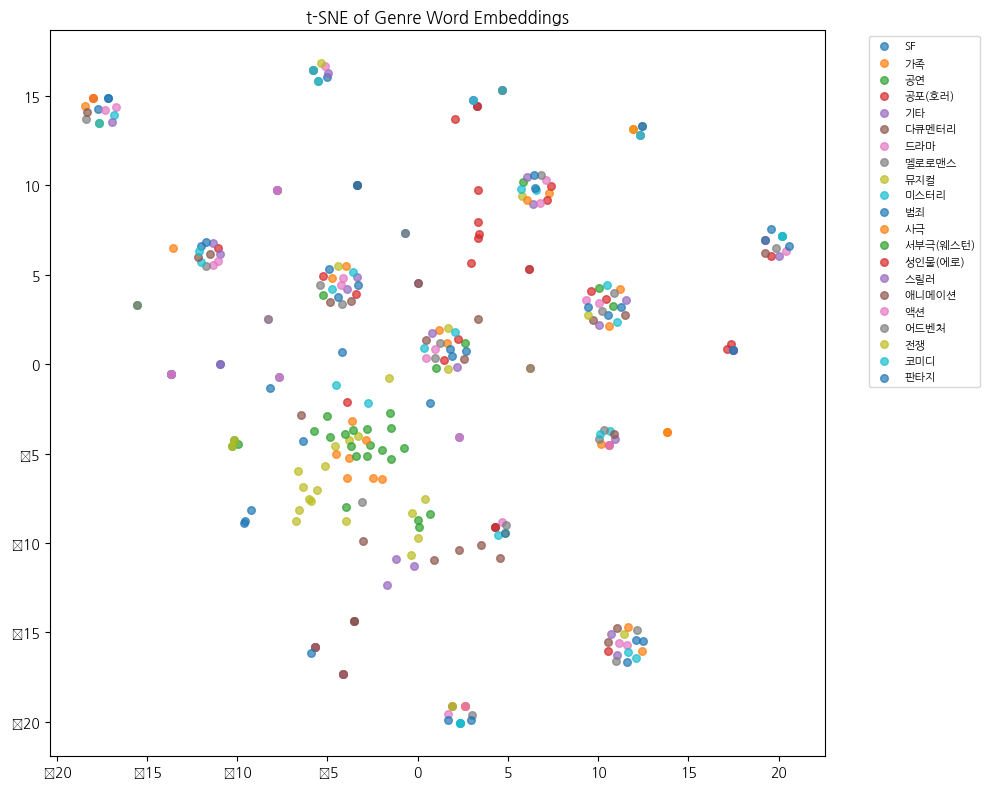

/tmp/ipython-input-1187611688.py:39: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


In [101]:
embedded_words, word_labels, word_genres = tsne_plot_genre_words(genre, model, max_words_per_genre=15)
embedded_centroids, centroid_names = tsne_plot_genre_centroids(genre, model)

# 추가 시각화 - 업데이트 필요

In [75]:
def extract_top_biased_pairs_from_matrix(
    weat_df: pd.DataFrame,
    top_n: int = 10,
    use_abs: bool = True,
) -> pd.DataFrame:
    """
    weat_df: build_weat_matrix로 만든 (장르×장르) WEAT 점수 DataFrame
    top_n : 가장 편향이 큰 (행, 열) 쌍을 몇 개까지 뽑을지
    use_abs : True면 |score| 기준으로 정렬 (보통 이게 '강한 편향' 의미)

    return: columns = ['genre_i', 'genre_j', 'score', 'abs_score']
    """
    # 1) 긴 형태(long format)로 변환
    long_df = weat_df.stack().reset_index()
    long_df.columns = ['genre_i', 'genre_j', 'score']

    # 2) 대각선(i==j) 제거
    long_df = long_df[long_df['genre_i'] != long_df['genre_j']]

    # 3) NaN 제거
    long_df = long_df.dropna(subset=['score'])

    # 4) abs_score 추가
    long_df['abs_score'] = long_df['score'].abs()

    # 5) 대칭 중복 제거 (i,j)와 (j,i)가 둘 다 있으면 하나만 남기기
    #    → 정렬된 튜플(작은이름, 큰이름)을 key로 사용
    long_df['pair_key'] = long_df.apply(
        lambda row: tuple(sorted([row['genre_i'], row['genre_j']])), axis=1
    )
    long_df = long_df.drop_duplicates(subset=['pair_key'])

    # 6) 정렬
    if use_abs:
        long_df = long_df.sort_values(by='abs_score', ascending=False)
    else:
        long_df = long_df.sort_values(by='score', ascending=False)

    # 7) Top-N만 리턴
    return long_df[['genre_i', 'genre_j', 'score', 'abs_score']].head(top_n)


In [76]:
def summarize_all_weat_results(
    weat_results: dict,
    top_n: int = 10,
    use_abs: bool = True,
) -> pd.DataFrame:
    """
    weat_results: {(attr_A_name, attr_B_name): weat_df, ...}
                  run_weat_for_all_genre_pairs에서 나온 dict 구조를 가정

    top_n: 각 (A,B) 페어마다 상위 몇 개의 (genre_i, genre_j) 쌍을 뽑을지
    use_abs: True면 |score| 기준 정렬

    return: 모든 (A,B) 페어에 대한 Top-N 레코드를 합친 DataFrame
            columns = ['attr_A', 'attr_B', 'genre_i', 'genre_j', 'score', 'abs_score']
    """
    rows = []

    for (attr_A_name, attr_B_name), weat_df in weat_results.items():
        top_df = extract_top_biased_pairs_from_matrix(
            weat_df,
            top_n=top_n,
            use_abs=use_abs,
        )

        top_df = top_df.copy()
        top_df['attr_A'] = attr_A_name
        top_df['attr_B'] = attr_B_name

        rows.append(top_df[['attr_A', 'attr_B', 'genre_i', 'genre_j', 'score', 'abs_score']])

    if not rows:
        return pd.DataFrame(columns=['attr_A', 'attr_B', 'genre_i', 'genre_j', 'score', 'abs_score'])

    summary_df = pd.concat(rows, ignore_index=True)
    return summary_df


In [78]:
# 2) 각 (A,B) 페어에 대해 가장 편향이 큰 장르쌍 Top-5만 뽑기 + 통합
summary_df = summarize_all_weat_results(
    weat_results=weat_results,
    top_n=5,
    use_abs=True,
)

print(summary_df.head(20))


   attr_A  attr_B  genre_i  genre_j     score  abs_score
0      SF      가족  성인물(에로)       전쟁 -1.566450   1.566450
1      SF      가족       가족       전쟁 -1.514339   1.514339
2      SF      가족    멜로로맨스       전쟁 -1.433211   1.433211
3      SF      가족       SF       가족  1.406535   1.406535
4      SF      가족       SF  성인물(에로)  1.385128   1.385128
5      SF      공연       SF       공연  1.729909   1.729909
6      SF      공연       공연    애니메이션 -1.629199   1.629199
7      SF      공연       공연     미스터리 -1.614799   1.614799
8      SF      공연       공연     어드벤처 -1.608976   1.608976
9      SF      공연       공연    다큐멘터리 -1.604792   1.604792
10     SF  공포(호러)    다큐멘터리    멜로로맨스  1.425915   1.425915
11     SF  공포(호러)    다큐멘터리  성인물(에로)  1.403155   1.403155
12     SF  공포(호러)    멜로로맨스       전쟁 -1.392751   1.392751
13     SF  공포(호러)  성인물(에로)       전쟁 -1.383296   1.383296
14     SF  공포(호러)      스릴러       전쟁 -1.307423   1.307423
15     SF      기타       SF       기타  1.479420   1.479420
16     SF      기타       SF  성인물

In [79]:
def visualize_summary_heatmap(summary_df):
    """
    summary_df: summarize_all_weat_results 로 만든 DF
    columns = ['attr_A','attr_B','genre_i','genre_j','score','abs_score']
    """
    # 장르 페어 이름 하나의 문자열로 합치기
    summary_df['genre_pair'] = summary_df['genre_i'] + " vs " + summary_df['genre_j']
    summary_df['attr_pair'] = summary_df['attr_A'] + " | " + summary_df['attr_B']

    # pivot 테이블 생성: 행 = attr페어, 열 = 장르페어, 값 = abs_score
    pivot_df = summary_df.pivot_table(
        index='attr_pair',
        columns='genre_pair',
        values='abs_score',
        aggfunc='mean'
    )

    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot_df, cmap='coolwarm', center=0)
    plt.title("WEAT Bias (|score|) Heatmap\nAttr-Pair × Genre-Pair")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [80]:
def visualize_summary_bar(summary_df, top_n=5):
    # |score| 기준 상위 N개만
    df = summary_df.copy()
    df = df.sort_values("abs_score", ascending=False).head(top_n)

    df["pair_label"] = df["genre_i"] + " vs " + df["genre_j"]
    df["attr_label"] = df["attr_A"] + " | " + df["attr_B"]

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df,
        x="abs_score",
        y="pair_label",
        hue="attr_label",
        dodge=False
    )
    plt.title(f"Top-{top_n} Most Biased Genre Pairs Across All Attribute Pairs")
    plt.xlabel("|WEAT score|")
    plt.ylabel("Genre Pair")
    plt.legend(title="Attr Pair", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [81]:
import networkx as nx

def visualize_summary_network(summary_df, threshold=0.5):
    """
    threshold: abs_score가 threshold 이상인 장르쌍만 edge로 표시
    """
    df = summary_df.copy()
    df = df[df['abs_score'] >= threshold]

    G = nx.Graph()

    for _, row in df.iterrows():
        g1 = row['genre_i']
        g2 = row['genre_j']
        weight = row['abs_score']

        G.add_edge(g1, g2, weight=weight)

    # 위치 계산 (Force-directed layout)
    pos = nx.spring_layout(G, k=0.8, seed=42)

    plt.figure(figsize=(10, 8))
    edges = G.edges(data=True)

    # edge 두께는 bias 강도
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color='skyblue',
        edge_color='gray',
        width=[d['weight']*2 for (_,_,d) in edges],
        font_size=10
    )
    plt.title(f"Bias Network (threshold={threshold})")
    plt.show()


In [82]:
def visualize_summary_scatter(summary_df):
    df = summary_df.copy()
    df["genre_pair"] = df["genre_i"] + " vs " + df["genre_j"]
    df["attr_pair"] = df["attr_A"] + " | " + df["attr_B"]

    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        data=df,
        x="genre_pair",
        y="abs_score",
        hue="attr_pair",
        size="abs_score",
        sizes=(20, 200),
        alpha=0.7
    )
    plt.title("Bias Strength Distribution by Attribute Pair")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("|WEAT Score|")
    plt.tight_layout()
    plt.show()


In [83]:
def visualize_all_summary_views(summary_df, top_n_bar=10, network_threshold=0.5):
    print("🔹 1) Heatmap (Attr-Pair × Genre-Pair)")
    visualize_summary_heatmap(summary_df)

    print("🔹 2) Barplot (Top-N 가장 편향이 큰 장르쌍)")
    visualize_summary_bar(summary_df, top_n=top_n_bar)

    print(f"🔹 3) Network Graph (threshold={network_threshold})")
    visualize_summary_network(summary_df, threshold=network_threshold)

    print("🔹 4) Scatter Plot (Bias Distribution)")
    visualize_summary_scatter(summary_df)


🔹 1) Heatmap (Attr-Pair × Genre-Pair)


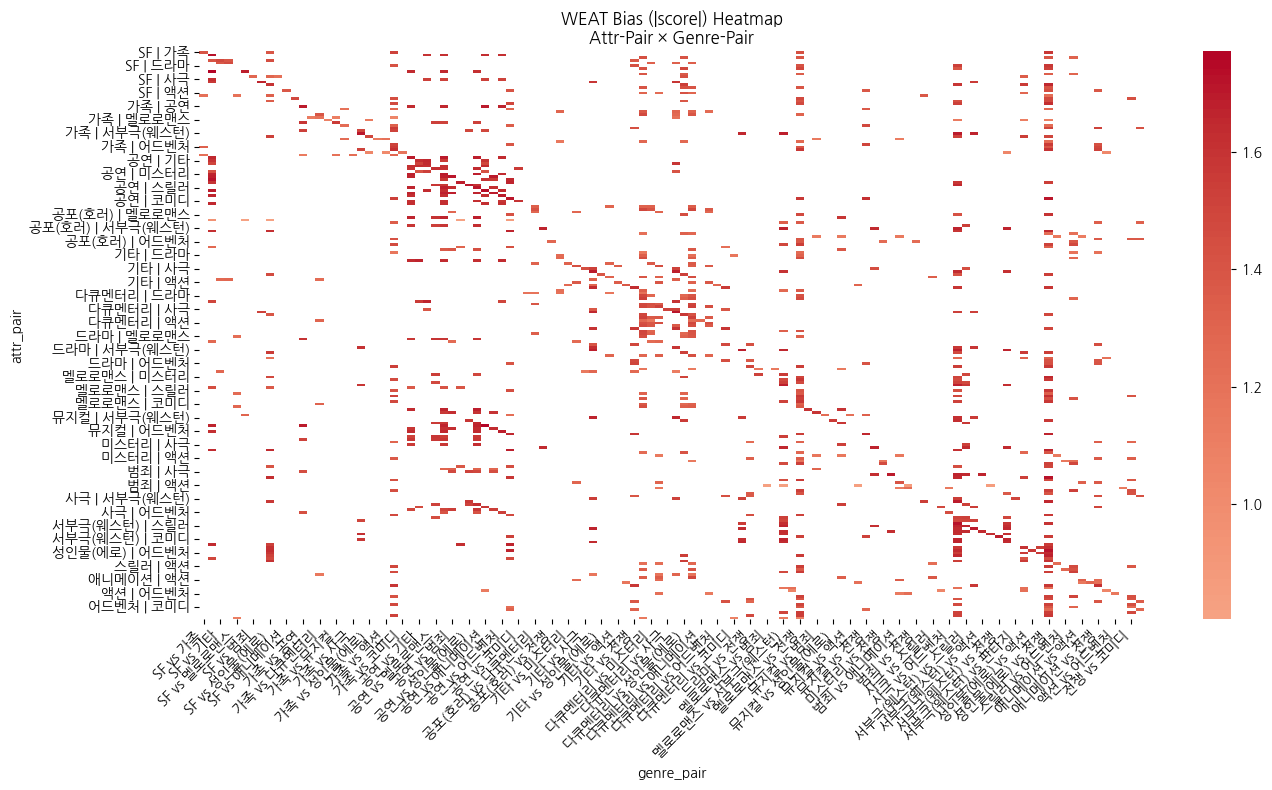

🔹 2) Barplot (Top-N 가장 편향이 큰 장르쌍)


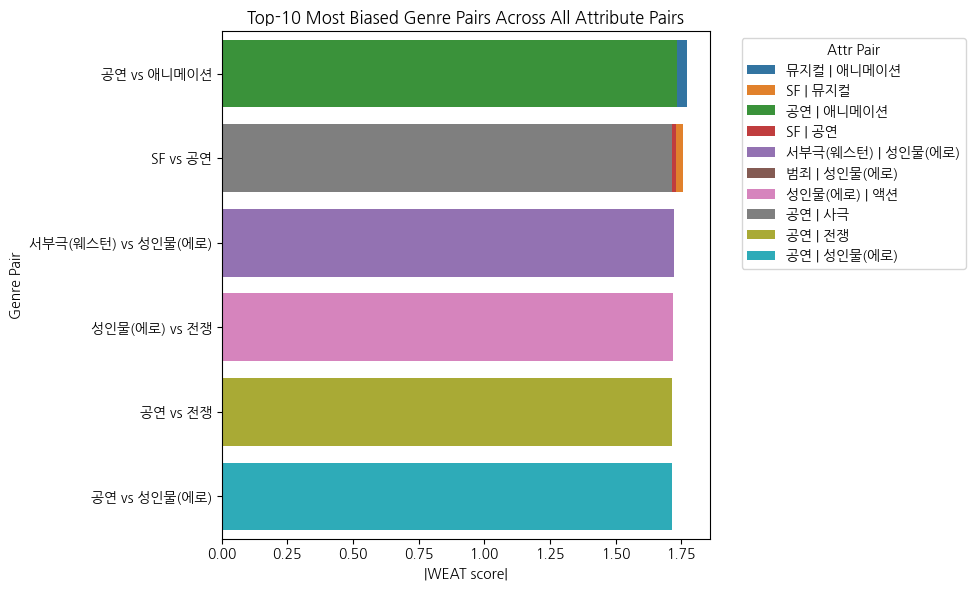

🔹 3) Network Graph (threshold=0.6)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

🔹 4) Scatter Plot (Bias Distribution)


/tmp/ipython-input-122830361.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


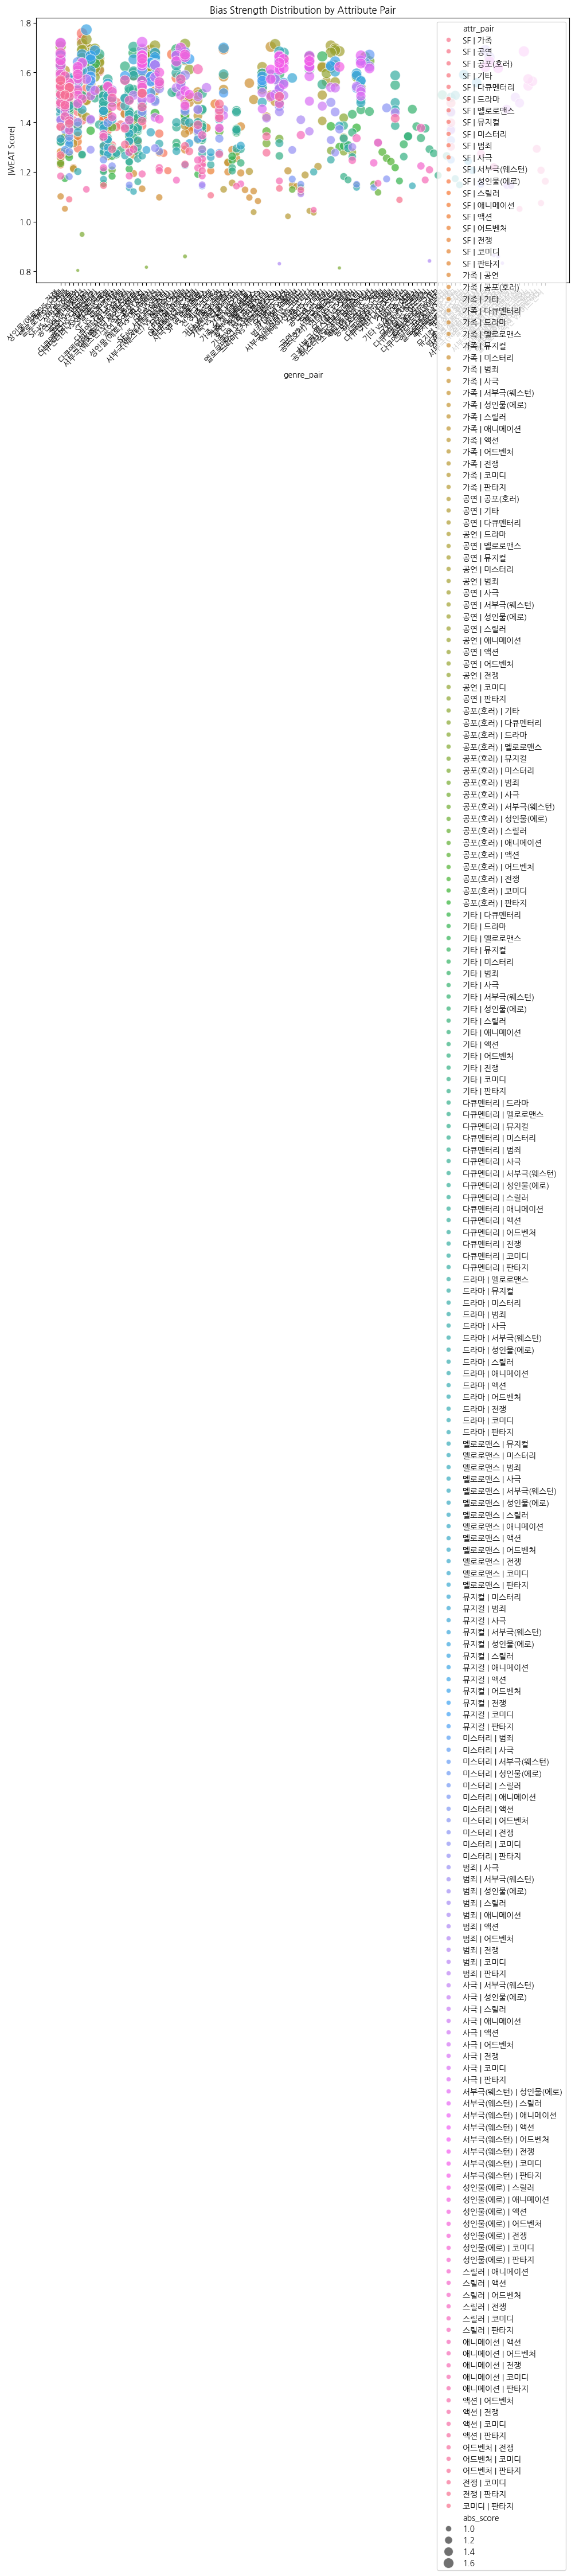

In [84]:
# summary_df는 summarize_all_weat_results(...) 결과라고 가정
visualize_all_summary_views(summary_df, top_n_bar=10, network_threshold=0.6)


# 결과

heatmap 출력 결과 장르 vs 구분, 구분 vs 장르의 결과는 유사하게 나타났다.

장르 vs 장르의 경우 추가적인 분석이 필요하긴 하나 대체로 사람이 생각하는 연관성과 유사한 결론을 도출한 것으로 보인다.

e.g. attribute가 SF, 뮤지컬인 경우 공연의 전체적인 편향성이 높게 나타났다.

# 고찰

# 회고